# ID5059 P2 Group Project

## Imports

Import relevant packages.

In [155]:
# reminder of which packages to install:
# pip install numpy pandas matplotlib scikit-learn seaborn imblearn xgboost optuna

# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore') # remove warnings

## Read in the data

Here we read in the information from the given CSV files. We drop the ID column as it's duplicated by pandas, and we also make a copy of the training data in order to test out some imputation methods on it. We separate out the independent variables from the response variable for this copy to obtain X_copy and Y_copy.

In [156]:
# read the data, dropping the ID column, as this is duplicated by pandas
raw_training_data = pd.read_csv(r"train.csv").drop(columns=["id"])
raw_test_data = pd.read_csv(r"test.csv").drop(columns=["id"])

# copy the raw training data
copy_raw_training_data = raw_training_data.copy()

# separate out the independent variables from the target
X_copy = copy_raw_training_data.drop(labels=['Status'], axis=1)
Y_copy = copy_raw_training_data["Status"]

## Data Analysis & Exploration

The main two ways we can understand our data is through both numerical and graphical analysis. The former allows us to quantify features of the data and the latter gives a more visual representation of our findings, which makes the information clearer and easier to understand.

### Numerical Analysis

We first look at how many data points we have as well as the number of attributes.

In [157]:
print(f"Train set shape: {raw_training_data.shape}") 
# print(f"Test set shape: {raw_test_data.shape}") # doesn't have the 'Status' column
# print()

Train set shape: (7905, 19)


This is plenty of data to train a model on, and since we only have 19 attributes we need not perform feature selection.

Now we want to see how many missing values each column has.

In [158]:
print(f"Null count for both data sets:")
print(pd.concat([raw_training_data.isnull().sum().astype(float), raw_test_data.isnull().sum().astype(int)], axis=1).rename(columns={0: 'Train Set', 1: 'Test Set'}))

Null count for both data sets:
               Train Set  Test Set
N_Days               0.0       0.0
Drug                 0.0       0.0
Age                  0.0       0.0
Sex                  0.0       0.0
Ascites              0.0       0.0
Hepatomegaly         0.0       0.0
Spiders              0.0       0.0
Edema                0.0       0.0
Bilirubin            0.0       0.0
Cholesterol          0.0       0.0
Albumin              0.0       0.0
Copper               0.0       0.0
Alk_Phos             0.0       0.0
SGOT                 0.0       0.0
Tryglicerides        0.0       0.0
Platelets            0.0       0.0
Prothrombin          0.0       0.0
Stage                0.0       0.0
Status               0.0       NaN


Since there are no missing values, we will have to delete data manually in order to assess different imputation methods. We made a copy of the original training data in order to remove values and not affect the data we have.

We now analyse the numerical features of the data. The function desctibe gives a summary of key information such as mean and standard deviation.

In [159]:
print("Summary of numerical features:")
print(raw_training_data.describe().round(3))

Summary of numerical features:
         N_Days        Age  Bilirubin  Cholesterol   Albumin    Copper  \
count  7905.000   7905.000   7905.000     7905.000  7905.000  7905.000   
mean   2030.173  18373.146      2.594      350.562     3.548    83.903   
std    1094.234   3679.959      3.813      195.379     0.346    75.899   
min      41.000   9598.000      0.300      120.000     1.960     4.000   
25%    1230.000  15574.000      0.700      248.000     3.350    39.000   
50%    1831.000  18713.000      1.100      298.000     3.580    63.000   
75%    2689.000  20684.000      3.000      390.000     3.770   102.000   
max    4795.000  28650.000     28.000     1775.000     4.640   588.000   

        Alk_Phos      SGOT  Tryglicerides  Platelets  Prothrombin     Stage  
count   7905.000  7905.000        7905.00   7905.000     7905.000  7905.000  
mean    1816.745   114.605         115.34    265.229       10.629     3.033  
std     1903.751    48.791          52.53     87.466        0.782   

Some of these features have vastly different distributions, and so in order to feed them into a machine learning model we will have to standardise them in some way.

Then we take a look at how many unique values each attribute has.

In [160]:
print(pd.concat([raw_training_data.nunique().rename('Unique count'), raw_training_data.dtypes.rename('Data type'), ], axis=1))

               Unique count Data type
N_Days                  461     int64
Drug                      2    object
Age                     391     int64
Sex                       2    object
Ascites                   2    object
Hepatomegaly              2    object
Spiders                   2    object
Edema                     3    object
Bilirubin               111   float64
Cholesterol             226   float64
Albumin                 160   float64
Copper                  171   float64
Alk_Phos                364   float64
SGOT                    206   float64
Tryglicerides           154   float64
Platelets               227   float64
Prothrombin              49   float64
Stage                     4   float64
Status                    3    object


Unsuprisingly, the numerical columns have many unique values. However it's helpful that the categorical columns all have very few unique values. This means that if we were to one-hot encode the data later on, we wouldn't create too many new columns. In particular, the attribues with only 2 unique values can be encoded with binary values.

We also want to have a look at how many instances we have of each response variable.

In [161]:
print("Proportion of each response variable:")
print(raw_training_data['Status'].value_counts() / np.shape(raw_training_data)[0])

Proportion of each response variable:
Status
C     0.628083
D     0.337128
CL    0.034788
Name: count, dtype: float64


This is slightly concerning to see. Since there is a severe unbalance of the response variables, we will need to account for this using various sampling methods. If we were to ignore this, our model would severely underfit on the CL category since there are so few instances with that response. It would also likely overfit on the C category since there are so many of them. As long as we use sampling methods we should be able to account for this.

### Graphical Analysis

We can now take the information we have found during our initial analysis and represent it with graphs. This will allow us to easily discern relationships between variables and also individual variable distributions.

First we take a look at a correlation matrix between the numerical attributes within the data.

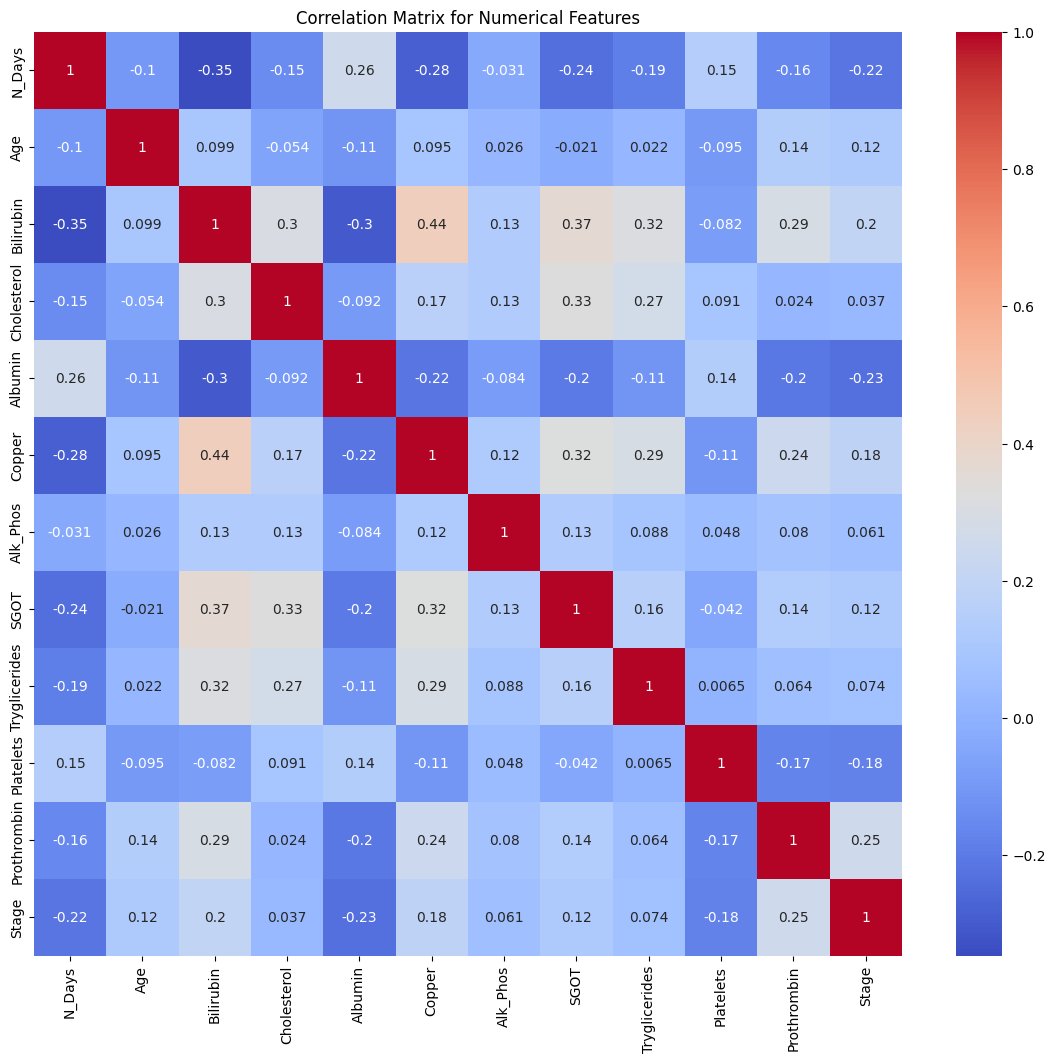

In [162]:
# specify which features contain numerical data
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

plt.figure(figsize=(14, 12))                                                                # create figure
sns.heatmap(raw_training_data[numerical_features].corr(), annot=True, cmap='coolwarm')      # use seaborn to create a correlation matrix
plt.title('Correlation Matrix for Numerical Features')                                      # label the figure and output it
plt.show()

None of the variables have too strong of a correlation with each other, the strongest positive correlation being Copper and Bilirubin with 0.44 and the strongest negative correlation being N_Days and Bilirubin with -0.35. This means that we don't have to worry about deleting any columns in order to avoid using diplicate data. It also shows that Bilirubin may be an important variable in the model since it seems to either influence or be influenced by other variables relatively strongly.

We now take a look at histrograms showing the distributions of all the numerical attributes. This can show us how each column is spread and hence help us make a decision on whether to standardise or normalise the data during the pipelining process.

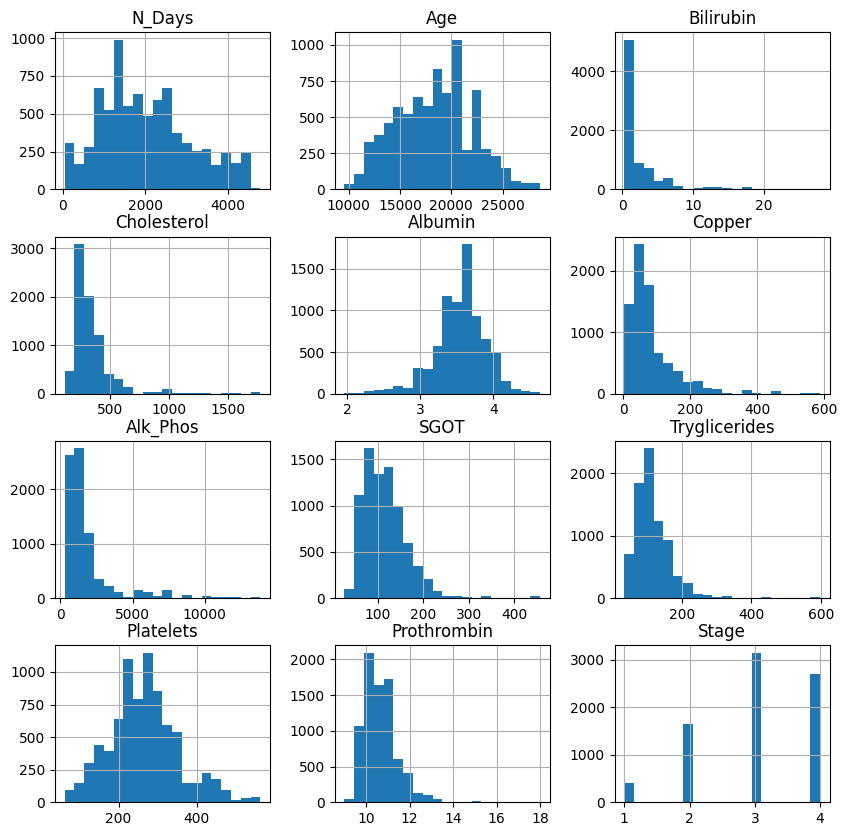

In [163]:
# plot histograms for numerical variables
raw_training_data.hist(bins=20, figsize=(10, 10))
plt.show()

These attributes mostly have normally distributed data, with some of them having outliers such as Bilirubin, Copper and Alk_Phos. This indicates that normalisation would be a poor choice of transformation for our dataset, since it handles outliers poorly. Hence we will use standardisation instead. We can now look in more detail at the outliers of some of these variables.

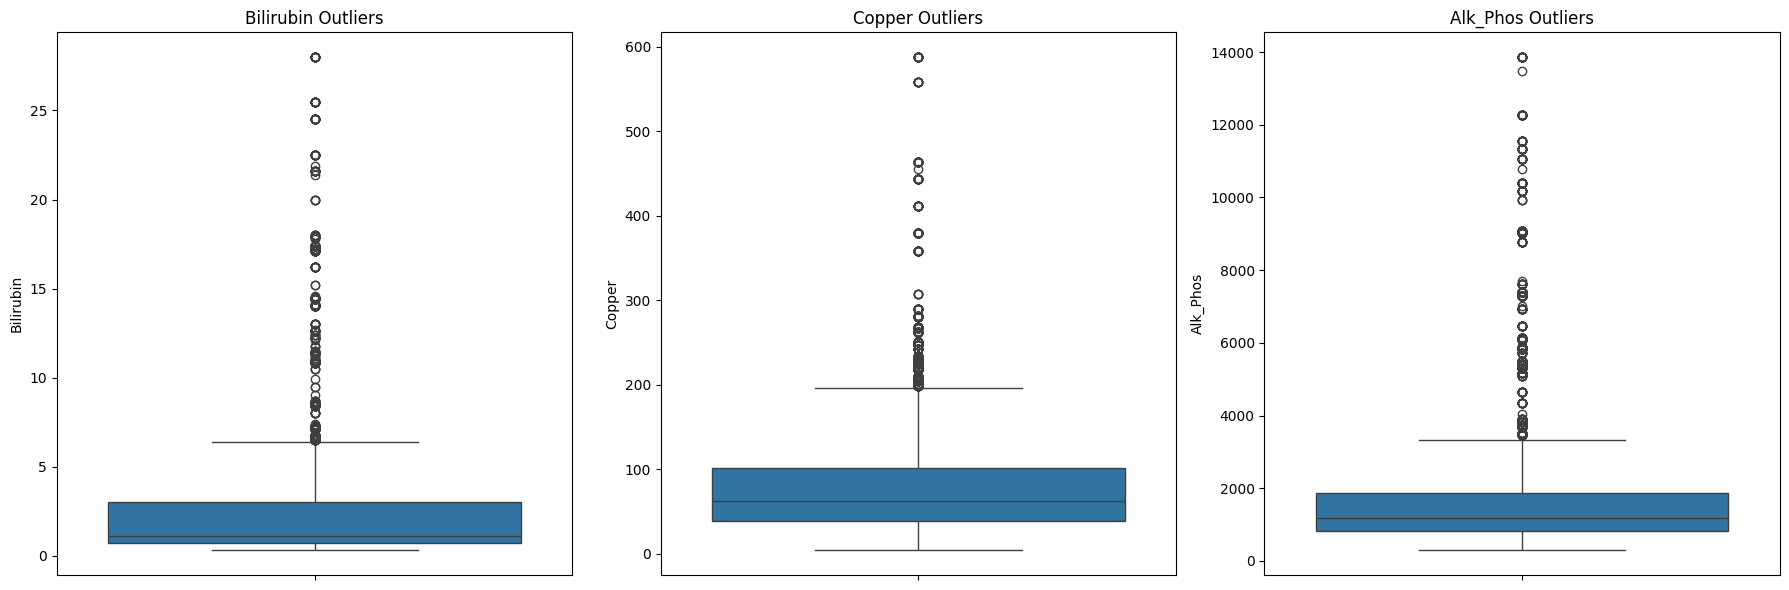

In [164]:
# Outlier Detection for 'Bilirubin', 'Copper', and 'Alk_Phos'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(ax=axes[0], data=raw_training_data['Bilirubin'], orient="v")
sns.boxplot(ax=axes[1], data=raw_training_data['Copper'], orient="v")
sns.boxplot(ax=axes[2], data=raw_training_data['Alk_Phos'], orient="v")
axes[0].set_title('Bilirubin Outliers')
axes[1].set_title('Copper Outliers')
axes[2].set_title('Alk_Phos Outliers')
plt.tight_layout()
plt.show()

It is now clear to see that all three of these attributes have a large amount of outliers, represented by the large quantity of dots above the horizontal lines on each plot.

We now want to have a look at each categorical variable, and how much of each respone they have.

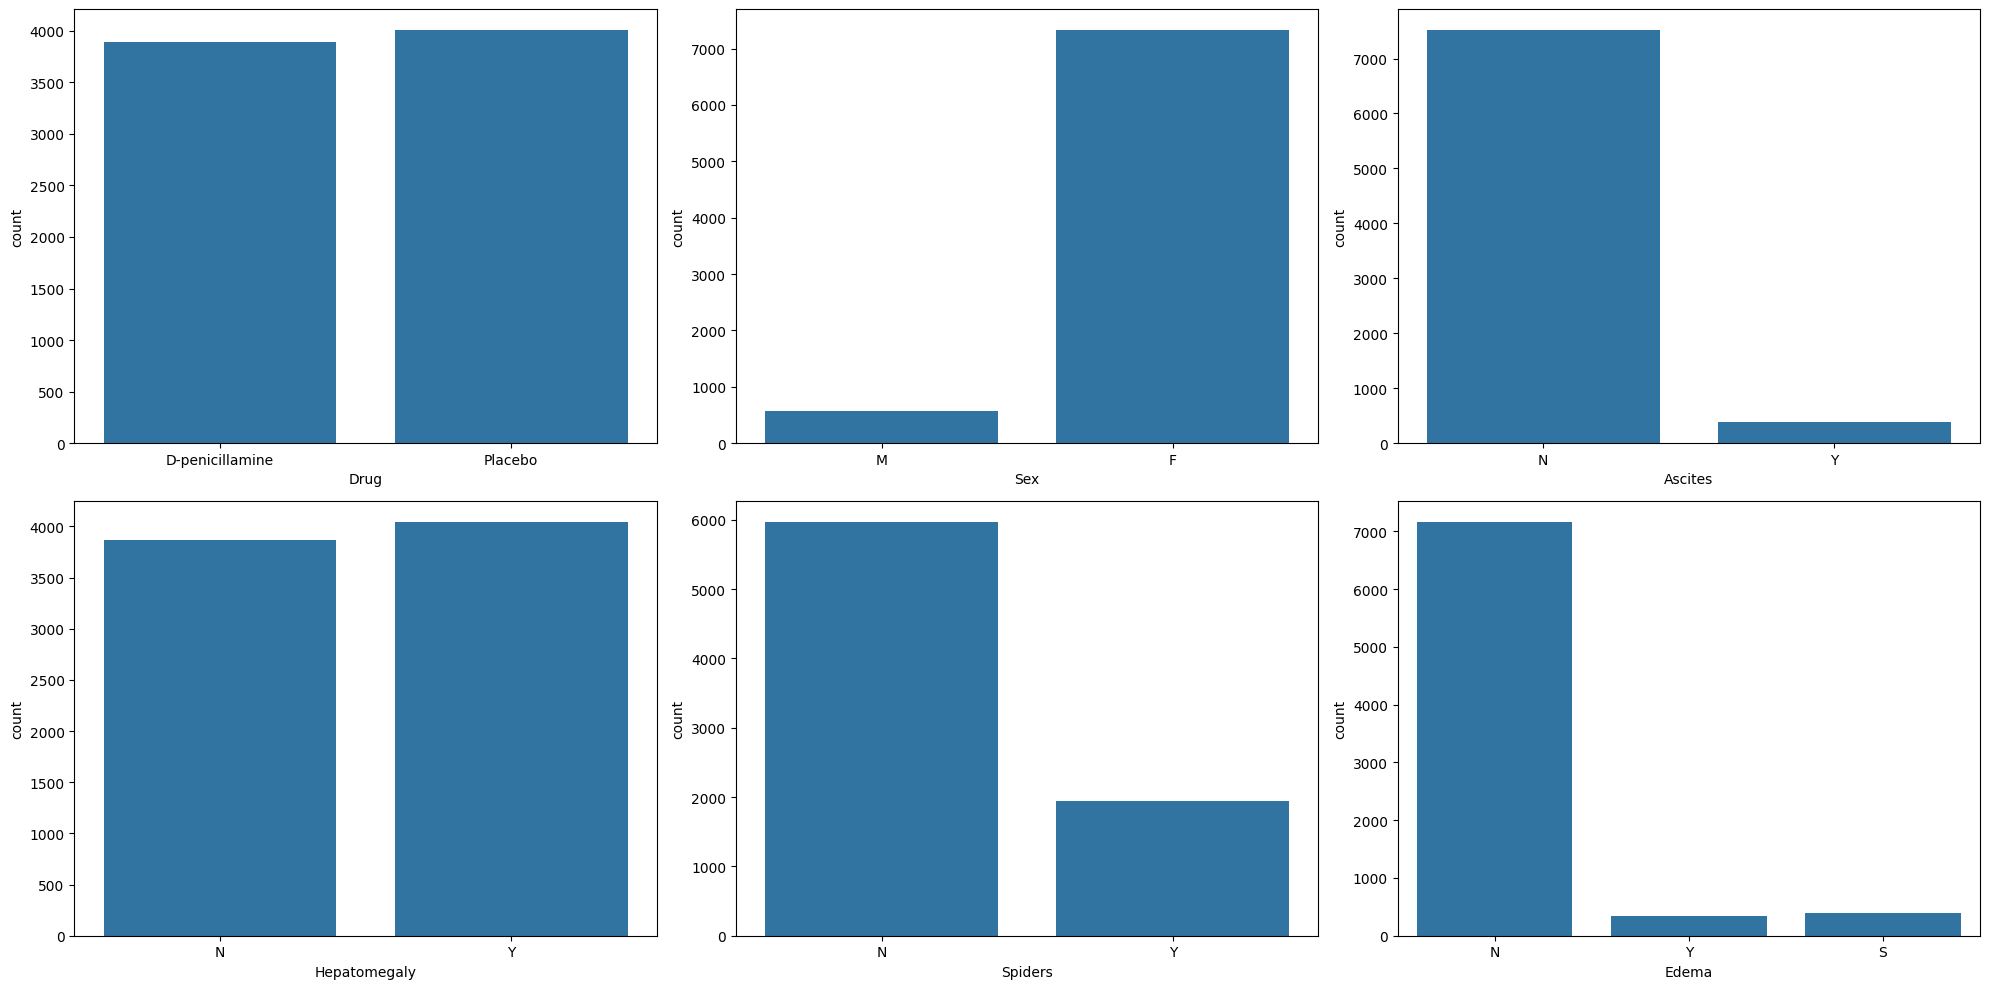

In [165]:
# Categorical Features Distribution
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, cat_feature in enumerate(categorical_features):
    sns.countplot(x=cat_feature, data=raw_training_data, ax=axes[i])
plt.tight_layout()
plt.show()

Some of these attributes are relatively balanced, such as Drug and Hepatomegaly, and others are less so. The categories with unbalanced data are not a problem for our model, in fact they may be helpful since it is possible that if a patient has one of the uncommon categories they could be more at risk from the disease. Hence these categories may be helpful for the final model.

We can also have a look at the distribution of different response variables graphically.

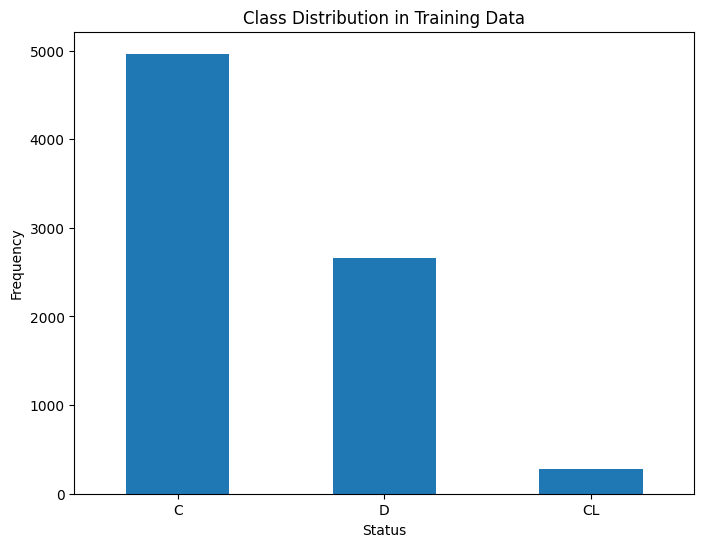

In [166]:
plt.figure(figsize=(8, 6))                                      # make a figure
raw_training_data['Status'].value_counts().plot(kind='bar')     # plot a bar chart for the status variable
plt.title('Class Distribution in Training Data')                # label the plot and set the size
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()                                                      # oputput the plot

It is clear to see that we have very unbalanced amounts of each of these response variables. As indicated before, we certainly have to deal with this using sampling methods later on.

Another key piece of information we can look at is how some features are distributed depending on the class they are in (what the response variable is).

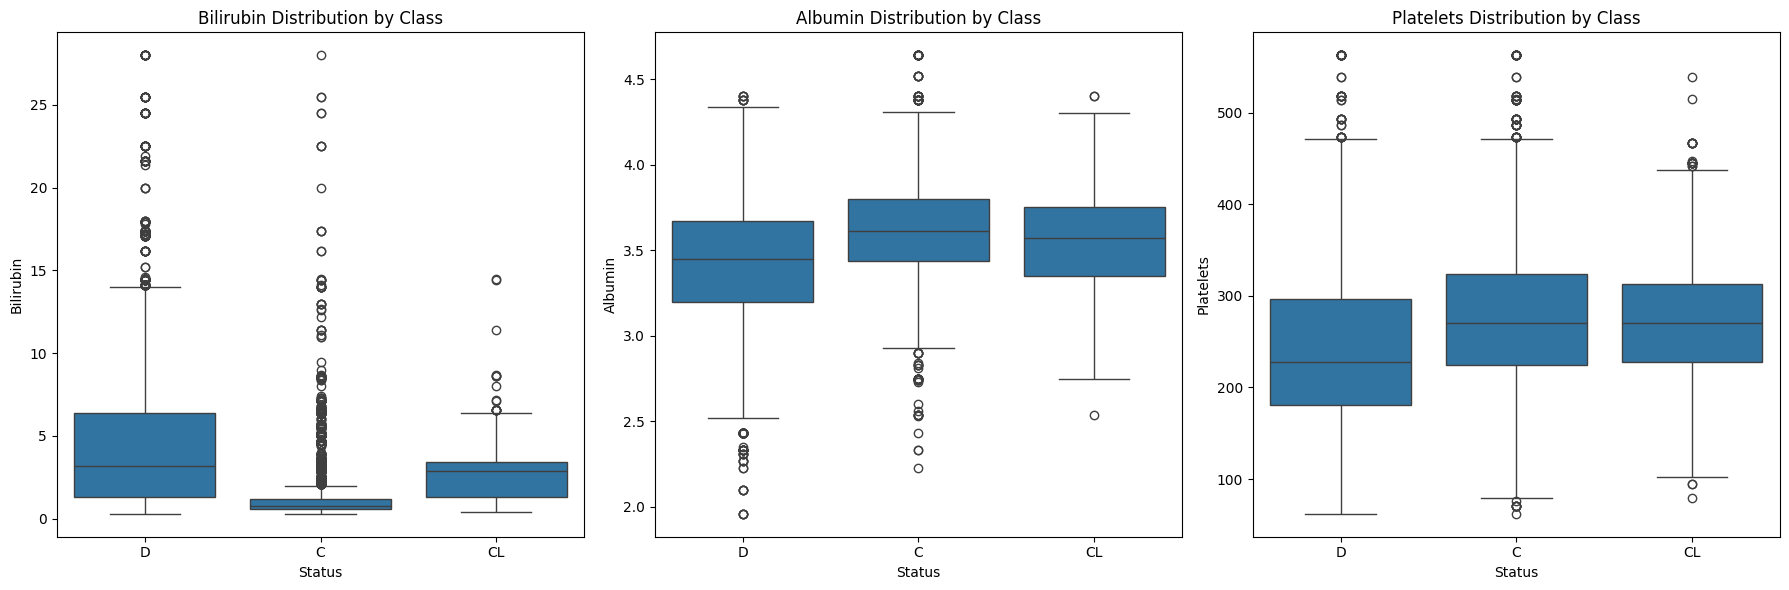

In [167]:
# Feature Distribution by Class for 'Bilirubin', 'Albumin', and 'Platelets'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))                                 # create a plot with subplots
sns.boxplot(ax=axes[0], x='Status', y='Bilirubin', data=raw_training_data)      # make a separate box plot for each of the features, separating out by class
sns.boxplot(ax=axes[1], x='Status', y='Albumin', data=raw_training_data)
sns.boxplot(ax=axes[2], x='Status', y='Platelets', data=raw_training_data)
axes[0].set_title('Bilirubin Distribution by Class')                            # label the plots and output them
axes[1].set_title('Albumin Distribution by Class')
axes[2].set_title('Platelets Distribution by Class')
plt.tight_layout()
plt.show()

Although the distributions by class are very similar for Albumin and Platelets (with a lot of overlap between the boxes), the Bilirubin category tells a different story. All three class distributions are relatively different, with the C distribution having little to no overlap at all with the others. This means that in theory we could obtain a model with relatively high accuracy using Bilirubin alone, and so this attribute will be very important in our model later on.

We can also explore the interaction effects between features, plotting Bilirubin and Albumin against one another and colouring the points depending on their class.

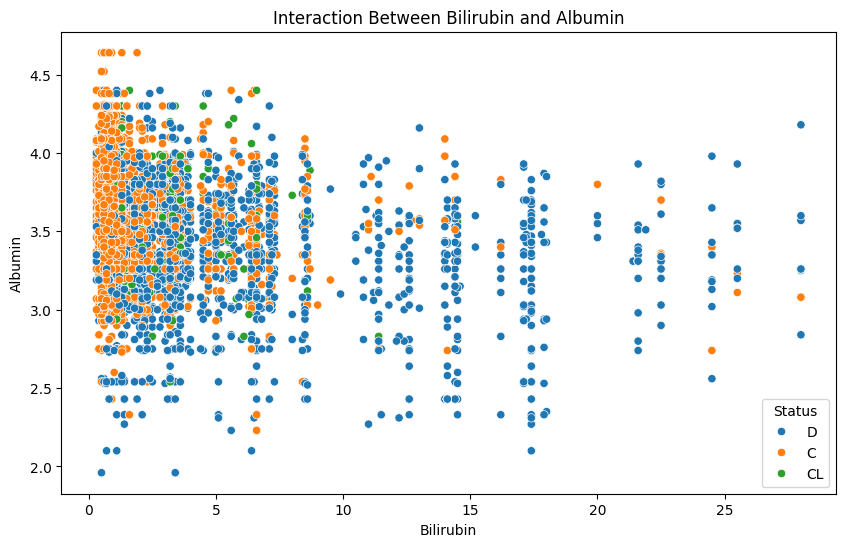

In [168]:
# Interaction Effects Between 'Bilirubin' and 'Albumin'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bilirubin', y='Albumin', hue='Status', data=raw_training_data)
plt.title('Interaction Between Bilirubin and Albumin')
plt.show()

It is unclear whether there is a strong effect from Albumin, however since many of the points past the 5 or 10 mark on the x-axis are blue, this shows that a high Bilirubin level correlates to a higher change of death.

Another way we can analyse the data is to look at the distribution of some numerical variables across the 3 different classes. Here we see what that looks like for Albumin, Bilirubin and Platelets.

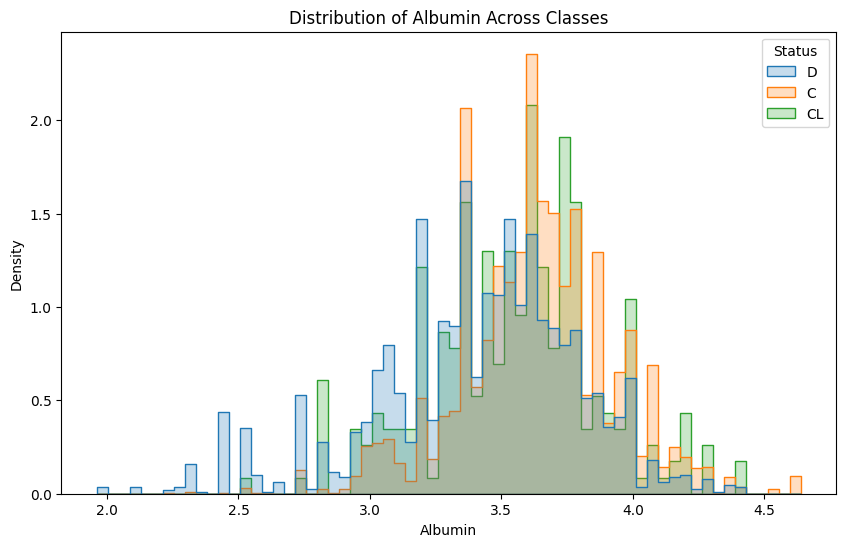

In [169]:
# Distribution of 'Albumin' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Albumin', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Albumin Across Classes')
plt.show()

This plot has a noticeably further right peak of the C and CL categories compared to D. This indicates that higher Albumin levels could correspond to a higher chance of survival. This attribute seems to be important for predicting the outcome for a patient, so it should certainly be included in the model.

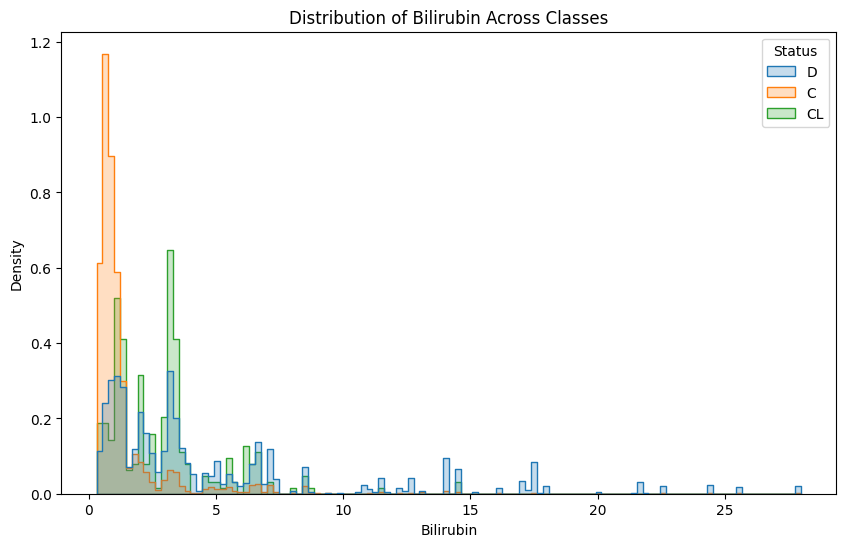

In [170]:
# Distribution of 'Bilirubin' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Bilirubin', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Bilirubin Across Classes')
plt.show()

As was indicated in the plot of the interaction between Bilirubin and Albumin, we can see a higher survival rate for patients with low levels of Bilirubin.

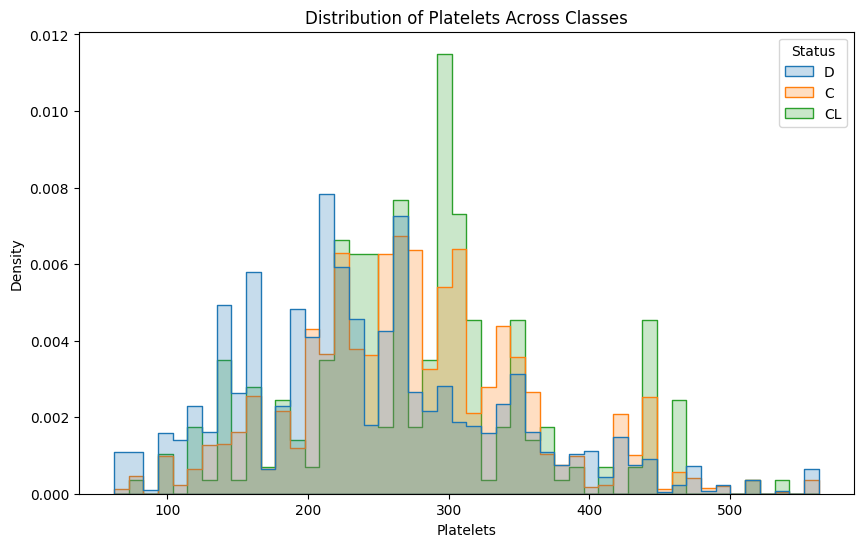

In [171]:
# Distribution of 'Platelets' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Platelets', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Platelets Across Classes')
plt.show()

Similarly to Albumin, this plot has a lower blue peak (class D) than the other 2 categories, indicating a lower survival rate for low Platelet levels.

All three of these variables seem to be important for the model, and we can quantify their performance much more accurately once we have fitted a model.

We can also check that the proportions of the status variable are similar for both the placebo and the given drug.

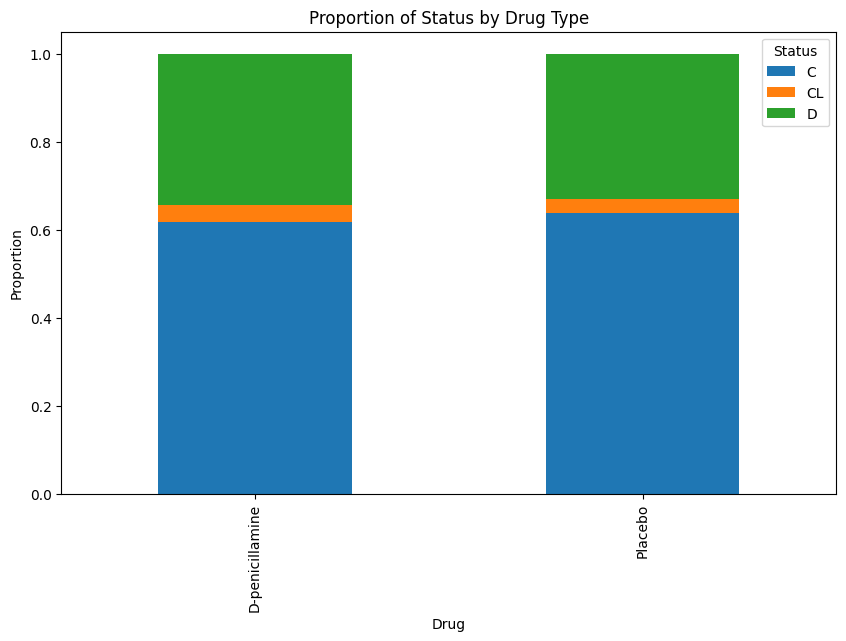

In [172]:
# Stacked Bar Chart for 'Drug' and 'Status'
cross_tab = pd.crosstab(index=raw_training_data['Drug'], columns=raw_training_data['Status'], normalize='index')
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of Status by Drug Type')
plt.ylabel('Proportion')
plt.show()

This shows that they are vary similar for both options for the Drug category. This may indicate that the drug had little effect on the outcome of patients, but once again we can conduct a more thorough investigation of feature importance at the end.

### Data Analysis Results

The main things that we have learned from our data analysis and exploration are the following:

* We have a large amount of data, which will be sufficient for training machine learning models

* There are no missing values in the data, so in order to assess imputation methods we must remove data on our own

* The categorical variables have few unique values, so encoding them will be relatively straightforward

* The distribution of response classes is very unbalanced, so we will need to perform sampling methods on our data in order to obtain the best models

* The numerical variables have many outliers, and so we should use standardisation instead of normalisation to transform our data

* Bilirubin seems to be an important variable for predicting the outcome of a patient

## Imputation Methods

We now want to explore different imputation methods and compare how effective they are. Since the data we have been given does not have any missing values, we will have to make a copy of it, remove some entries manually, then use various methods to impute the data back and assess each one.

The two methods we will use to compare imputation methods are the following:
* Calculate the RMSE of imputed numerical values and the accuracy and f1 score of imputed categorical values. Plot these on a graph.
* Train a simple random forest model on each imputed dataset and compare their performances when uploaded onto Kaggle.

### Functions for Imputation

The functions defined below are used in the imputation section. Explanations of what they do are given as comments at the start of each function.

In [173]:
def add_missing_values(X_full, Y_full, missing_rate):
    """
    Takes a dataframe and adds in some missing values (replaces them with NaN).

    Parameters:
    - X_full: a dataframe containing all columns with independent variables
    - Y_full: a dataframe containing the response variable column only
    - missing_rate: a float between 0 and 1 which specifies the proportion of missing values to add

    Returns:
    - X_missing: the dataframe X_full but with some missing values
    - Y_missing: an exact copy of Y_full
    - actual_entries_store: dictionary containing all entries that were set to NaN, keys are the data frames columns
    """
    # set a seed for reproducibility
    np.random.seed(24)
    
    # copy the input dataframes
    X_missing = X_full.copy()
    y_missing = Y_full.copy()

    # create empty dictionary to store values of entries before setting them to nan
    actual_entries_store = {}

    # remove a percentage of entries in each column at random, specified by missing_rate
    for col in X_missing.columns:
        index_list = X_missing.sample(frac=missing_rate+random.uniform(-0.01, 0.01)).index  # sample a proportion of the indices within the column, with a random component for the rate
        actual_entries_store[col] = []
        for value in index_list:
            actual_entries_store[col].append(X_missing.loc[value, col])   # store the actual entries in the dictionary
        X_missing.loc[index_list, col] = np.nan # replace the values with nan

    return X_missing, y_missing, actual_entries_store

In [174]:
def get_imputed_values(imputed_data, null_entries):
    """
    Gets the value of all the imputed entries and outputs them in a dictionary.
    
    Parameters:
    - imputed_data: the dataframe containing some actual values and some imputed values
    - null_entries: the locations of all the entries which were NaN before imputation

    Returns:
    - imputed_entries_store: dictionary containing all imputed entries, keys are the data frames columns
    """
    imputed_entries_store = {} # create dictionary for storing the actual values in the locations that are removed
    
    for row, col in null_entries: # loop over every removed entry:
        col_name = imputed_data.columns[col] # store column name of current null entry
        if col_name not in imputed_entries_store: # check if column name is already in the dictionary
            imputed_entries_store[col_name] = [] # if not already in dictionary, create empty list
        imputed_entries_store[col_name].append(imputed_data.iloc[row, col])# add actual value to the list for correct column

    return imputed_entries_store

In [175]:
def calc_num_metrics(actual_entries_store, imputed_entries_store, num_cols):
    """
    Calculates performance metric RMSE for numerical variables for the imputation method.
    
    Parameters:
    - actual_entries_store: dictionary containing all entries that were set to NaN, keys are the data frames columns
    - imputed_entries_store: dictionary containing all imputed entries, indexed the same as actual_entries_store
    - num_cols: list of the numerical columns in the data frame
    
    Returns:
    - Data frame as a string showing the RMSE for the imputation method for each numerical variable
    """
    numerical_data = []
    for col_name, actual_vals in actual_entries_store.items(): # loop over all variables and actual values
        if col_name in num_cols: # if the current column is numerical:
            # change imputed and actual values to be numeric
            imputed_vals = pd.to_numeric(imputed_entries_store.get(col_name, []))
            actual_vals = pd.to_numeric(actual_vals)
            numerical_data.append({"Variable": col_name, "RMSE": round(mean_squared_error(actual_vals, imputed_vals, squared=False),3)}) # add the column name and its RMSE
    
    return pd.DataFrame(numerical_data)

In [176]:
def calc_categorical_metrics(actual_entries_store, imputed_entries_store, categorical_cols):
    """
    Calculates performance metric accuracy and F1 score for categorical variables for the imputation method.
    
    Parameters:
    - actual_entries_store: dictionary containing all entries that were set to NaN, keys are the data frames columns
    - imputed_entries_store: dictionary containing all imputed entries, indexed the same as actual_entries_store
    - categorical_cols: list of the categorical columns in the data frame
    
    Returns:
    - Data frame as a string showing the accuracy and F1 score for the imputation method for each categorical variable
    """
    categorical_data = []
    for col_name in categorical_cols: # loop over all categorical variables
        # change imputed and actual values to be a string
        imputed_vals = [str(val) for val in imputed_entries_store.get(col_name, [])]
        actual_vals = [str(val) for val in actual_entries_store[col_name]]
        accuracy = accuracy_score(actual_vals, imputed_vals) # calculate accuracy score
        precision = precision_score(actual_vals, imputed_vals, average='weighted') # calculate precision score
        recall = recall_score(actual_vals, imputed_vals, average='weighted') # calculate recall score
        f1 = f1_score(actual_vals, imputed_vals, average='weighted') # calculate F1 score
        categorical_data.append({"Variable": col_name, "Accuracy": round(accuracy, 3), "Precision": round(precision, 3),"Recall": round(recall, 3),"F1 Score": round(f1, 3)}) # add the column name and its accuracy, precision, recall, and F1 score    
    return pd.DataFrame(categorical_data)

In [177]:
def numerical_encode(X):
    """
    Encodes the categorical variables in a given dataframe numerically.
    
    Parameters:
    - X: dataframe, should have columns labelled "Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"
    
    Returns:
    - X_encoded: dataframe with categorical variables encoded numerically
    """

    # make a copy of the dataframe
    X_encoded = X.copy()

    # specify how each numerical column should be encoded
    encodings = {
        "Drug": {"Placebo": 0, "D-penicillamine": 1},
        "Sex": {"F": 0, "M": 1},
        "Ascites": {"N": 0, "Y": 1},
        "Hepatomegaly": {"N": 0, "Y": 1},
        "Spiders": {"N": 0, "Y": 1},
        "Edema": {"N": 0, "Y": 1, "S": 2}
    }

    # replace the values in categorical columns by their encoded values
    X_encoded = X_encoded.replace(encodings)

    # output the encoded dataframe
    return X_encoded

In [178]:
# specify the inverse of the encoding before the function, since 'decodings' is later used outside the function as well 
decodings = {"Drug": {0: "Placebo", 1: "D-penicillamine"},
        "Sex": {0: "F", 1: "M"},
        "Ascites": {0: "N", 1: "Y"},
        "Hepatomegaly": {0: "N", 1: "Y"},
        "Spiders": {0: "N", 1: "Y"},
        "Edema": {0: "N", 1: "Y", 2: "S"}}

def reverse_numerical_encode(X, decodings_dict):
    """
    Reverses the numerical encoding process by replacing numerical values in categorical columns with the closest category.
    
    Parameters:
    - X: dataframe which has its categorical columns encoded
    - decodings_dict: dictionary which stores the necessary decodings
    
    Returns:
    - X_decoded: dataframe with categorical columns decoded
    """

    # make a copy of the input dataframe
    X_decoded = X.copy()

    # replace each categorical column with numbers closest to the ones in the list above
    for col in decodings_dict:
        new_col = []                            # stores a replacement column with numbers that correspond to decodings
        for entry in X_decoded[col]:
            closest_val = 0                     # stores the closest value so far, returns 0 if entry is nan
            min_dist = 100                      # stores highscore of minimum distance, starts very high to ensure it's overtaken
            for option in decodings_dict[col]:
                dist = abs(option - entry)      # calculate the distance of the given entry to each option
                if dist < min_dist:
                    closest_val = option        # updates closest value and minimum distance if it's a new highscore
                    min_dist = dist
            new_col.append(closest_val)         # adds the final closest value to the new column
        new_col_df = pd.DataFrame(new_col)      # makes the replacement column into a dataframe and replaces the old column with it
        X_decoded[col] = new_col_df

    # apply the reverse encoding now that all entries are options for categories
    X_decoded = X_decoded.replace(decodings_dict)

    # output the decoded dataframe
    return X_decoded

In [179]:
def predict_imputed_model(X, Y, raw_data, cat_cols):
    """
    Creates a random forest model using the input data set by encoding categorical columns.
    Stores the csv of predicitons for kaggle submission.
    
    Parameters:
    - X: data set, excluding the response variable
    - Y: response variable of data set
    - raw_data: dataframe to apply the classifier to and get predicted probabilities
    - cat_cols: columns which contain categorical data
    
    Returns:
    - Stores the csv file in current directory when 'predictions.to_csv("predictions.csv", index=False)' is run.
    """

    # make a copy of each of the input data frames
    X_copy = X.copy()
    Y_copy = Y.copy()
    raw_data_copy = raw_data.copy()

    # encode the independent variables using a built-in function
    X_encoded = pd.get_dummies(X_copy, columns=cat_cols)

    # use a dictionary to store the parameters for the random forest
    forest_params = {"criterion": "log_loss", 
                    "max_depth": 30, 
                    "max_features": 5,
                    "min_samples_leaf": 1, 
                    "min_samples_split": 8, 
                    "n_estimators": 100,
                    "random_state": 42}

    # create the random forest classifier using the given parameters, then fit it to the input data
    classifier = RandomForestClassifier(**forest_params)
    classifier.fit(X_encoded, Y_copy)
    predictions = pd.DataFrame(classifier.predict_proba(raw_data_copy), columns=['Status_C', 'Status_CL', 'Status_D'])
    
    # Use the code 'predictions.to_csv("predictions.csv", index=False)' to convert to a csv file for submission to kaggle
    return # predictions.to_csv("predictions.csv", index=False) **REMOVE # to save in directory**

### Imputation method comparison

Now we can prepare our copy of the training data for our imputation models.
* Store lists of numerical and categorical column names
* Scale the numerical data using StandardScaler
* Apply the "add_missing_values" function to the copy of the training data
* Store the locations of the null entries

In [180]:
# set random seed for reproducability
random.seed(24)

# store the names of all categorical and numerical columns (excluding the response variable)
categorical_cols = [col for col in X_copy.select_dtypes(include=['object']).columns.tolist()]
num_cols = [x for x in X_copy.columns if x not in categorical_cols]

# scale the numerical data using StandardScaler
scaler = StandardScaler()
X_copy_num = X_copy.drop(categorical_cols, axis=1)
X_copy_num_scaled = pd.DataFrame(scaler.fit_transform(X_copy_num), columns=X_copy_num.columns)

# replace the numerical columns in X_copy with the scaled versions
for col in X_copy.columns:
    if col in X_copy_num_scaled.columns:
        X_copy[col] = X_copy_num_scaled[col]

# apply the add_missing_values function to our data
X_miss, Y_miss, actual_entries_X = add_missing_values(X_copy, Y_copy, 0.05)

# create a list to store all of the entries which are null: (row, column)
null_entries_X = [(row_index, col_index) 
                for row_index, row in enumerate(X_miss.values) 
                for col_index, val in enumerate(row) 
                if pd.isnull(val)]

It is also important in the analysis of the imputation methods to compare each one to a baseline. In this case, the most sensible choice is to use non-imputed data and see how the imputation methods compare to that.

In [181]:
# Below is code to convert the test data to be used in the 'predict_imputed_model' function
raw_test_data_imputation = raw_test_data.copy()

# scale the numerical data using StandardScaler
raw_test_data_imputation_num = raw_test_data_imputation.drop(categorical_cols, axis=1)
raw_test_data_imputation_scaled = pd.DataFrame(scaler.fit_transform(raw_test_data_imputation_num), columns=raw_test_data_imputation_num.columns)

# replace the numerical columns in X_copy with the scaled versions
for col in raw_test_data_imputation.columns:
    if col in raw_test_data_imputation_scaled.columns:
        raw_test_data_imputation[col] = raw_test_data_imputation_scaled[col]

# encode the categorical columns of the test data using a built-in function
raw_test_data_imputation_encoded = pd.get_dummies(raw_test_data_imputation, columns=categorical_cols)

# run the predict_imputed_model function on the test data without imputing it at all. This gives us a baseline to compare the other methods to
predict_imputed_model(X_copy, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

KeyboardInterrupt: 

We now have all the components we need in order to test out our different imputation methods:
* random seed is set
* X_miss and Y_miss can be duplicated and the imputation methods can be applied to each of the copies
* actual_entries_X stores the original values from X_copy which have now been replaced by NaN
* null_entries_X stores the locations of all NaN values in X_miss
* categorical_cols and num_cols store the names of categorical and numerical columns respectively

So now all we need to do for each imputation method is the following:
* make a new copy of X_miss
* apply the imputation algorithm to the copy
* apply the get_imputed_values function to the resulting dataset
* apply the calc_num_metrics and calc_categorical_metrics functions to assess the performance of the imputation
* apply the predict_imputed_model function to test the performance of a model trained on this dataset

#### Imputation 1: Replace missing numerical values with the median for that column and missing categorical variables with the mode for that column

In [ ]:
# make a copy of the data with missing values
X_miss_copy1 = X_miss.copy()

# separate the numerical and categorical data
X_miss_copy1_num = X_miss_copy1.drop(categorical_cols, axis=1)
X_miss_copy1_cat = X_miss_copy1.drop(num_cols, axis=1)

# create a simple imputer and apply it to the numerical columns
imputer1_num = SimpleImputer(strategy='median')
X_miss_copy1_num = pd.DataFrame(imputer1_num.fit_transform(X=X_miss_copy1_num, y=Y_miss), columns=X_miss_copy1_num.columns) # apply the imputer to the data with missing values

# create a simple imputer and apply it to the categorical columns
imputer1_cat = SimpleImputer(strategy='most_frequent')
X_miss_copy1_cat = pd.DataFrame(imputer1_cat.fit_transform(X=X_miss_copy1_cat, y=Y_miss), columns=X_miss_copy1_cat.columns) # apply the imputer to the data with missing values

# combine the imputed dataframes back together
for col in X_miss_copy1.columns:
    if col in X_miss_copy1_num.columns:
        X_miss_copy1[col] = X_miss_copy1_num[col]
    else:
        X_miss_copy1[col] = X_miss_copy1_cat[col]

# get the imputed values from this imputation method and store them
imputed1_entries_store = get_imputed_values(X_miss_copy1, null_entries_X)

# display performance metrics
print("Numerical variables performance for imputation 1:")
print(calc_num_metrics(actual_entries_X, imputed1_entries_store, num_cols).to_string(index=False))
print("\nCategorical variables performance for imputation 1:")
print(calc_categorical_metrics(actual_entries_X, imputed1_entries_store, categorical_cols).to_string(index=False))

# save the predicted probabilities for the test data set as a csv file to be submitted to kaggle
predict_imputed_model(X_miss_copy1, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

Numerical variables performance for imputation 1:
     Variable  RMSE
       N_Days 1.040
          Age 0.983
    Bilirubin 1.148
  Cholesterol 0.992
      Albumin 1.034
       Copper 1.011
     Alk_Phos 0.907
         SGOT 0.917
Tryglicerides 1.210
    Platelets 0.976
  Prothrombin 1.043
        Stage 1.018

Categorical variables performance for imputation 1:
    Variable  Accuracy  Precision  Recall  F1 Score
        Drug     0.512      0.262   0.512     0.347
         Sex     0.939      0.881   0.939     0.909
     Ascites     0.945      0.893   0.945     0.919
Hepatomegaly     0.550      0.302   0.550     0.390
     Spiders     0.779      0.608   0.779     0.683
       Edema     0.899      0.808   0.899     0.851


#### Imputation 2: Impute each missing value with the mean value from k nearest neighbours

In [ ]:
# make a copy of the data with missing values
X_miss_copy2 = X_miss.copy()

# encode the categorical data to be numerical
X_miss_copy2 = numerical_encode(X_miss_copy2)

# create a KNN imputer and apply it to this copy of the data
imputer2 = KNNImputer(n_neighbors=89, weights="uniform")    # create a KNN imputer
X_miss_copy2 = pd.DataFrame(imputer2.fit_transform(X=X_miss_copy2, y=Y_miss), columns=X_miss_copy2.columns) # apply the imputer to the data with missing values

# reverse the numerical encoding of the categorical data
X_miss_copy2 = reverse_numerical_encode(X_miss_copy2, decodings)

# get the imputed values from this imputation method and store them
imputed2_entries_store = get_imputed_values(X_miss_copy2, null_entries_X)

# display performance metrics
print("Numerical variables performance for imputation 2:")
print(calc_num_metrics(actual_entries_X, imputed2_entries_store, num_cols).to_string(index=False))
print("\nCategorical variables performance for imputation 2:")
print(calc_categorical_metrics(actual_entries_X, imputed2_entries_store, categorical_cols).to_string(index=False))

# save the predicted probabilities for the test data set as a csv file to be submitted to kaggle
predict_imputed_model(X_miss_copy2, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

Numerical variables performance for imputation 2:
     Variable  RMSE
       N_Days 1.084
          Age 1.005
    Bilirubin 1.184
  Cholesterol 1.019
      Albumin 1.098
       Copper 1.056
     Alk_Phos 0.873
         SGOT 0.974
Tryglicerides 1.221
    Platelets 1.005
  Prothrombin 1.117
        Stage 1.079

Categorical variables performance for imputation 2:
    Variable  Accuracy  Precision  Recall  F1 Score
        Drug     0.514      0.514   0.514     0.514
         Sex     0.939      0.881   0.939     0.909
     Ascites     0.934      0.893   0.934     0.913
Hepatomegaly     0.509      0.518   0.509     0.510
     Spiders     0.752      0.689   0.752     0.705
       Edema     0.862      0.809   0.862     0.835


#### Imputation 3: Linear Regression and Decision Tree

* For numerical variables, implement linear regression using the non-null rows to determine the regression lines
* For rows with more 2 or 3 missing values, fill in 1 or 2, respecitvely, entries with the median for that column
* For categorical variables, implement a decision tree classifier to impute the missing entries

In [ ]:
# make a copy of the data with missing values
X_miss_copy3 = X_miss.copy()

np.random.seed(24)
# Store the missing data frame for only numerical variables. Store another data frame by dropping the null rows.
num_missing_raw_training_data = X_miss_copy3.drop(categorical_cols, axis=1)
linear_regres_df = num_missing_raw_training_data.dropna()

# fit linear regression models (for each numerical variable as the response) and store the coefficients and intercepts
regressions = {col: {'intercept': LinearRegression().fit(linear_regres_df.drop(col, axis=1),linear_regres_df[col]).intercept_,
                     'coeffs': LinearRegression().fit(linear_regres_df.drop(col, axis=1),linear_regres_df[col]).coef_}
               for col in linear_regres_df.columns}

# identify the rows with 1 missing value, and more than 1 missing value
rows_with_one_missing = num_missing_raw_training_data[num_missing_raw_training_data.isnull().sum(axis=1) == 1]
rows_with_over1_missing = num_missing_raw_training_data[num_missing_raw_training_data.isnull().sum(axis=1) >= 2]

# impute missing values using the median of the column in the rows with 2 or more missing values
median_vals = num_missing_raw_training_data.median() # store median value for each column in missing data frame
for idx, row in rows_with_over1_missing.iterrows(): # loop over rows with more than 1 missing value:
    missing_indices = row.isnull() # store the columns in current row with null entries
    fill_indices = np.random.choice(missing_indices[missing_indices].index, missing_indices.sum() - 1, replace=False) # sellect indicies to fill at random
    rows_with_over1_missing.loc[idx, fill_indices] = median_vals[fill_indices] #fill these entries using median of the column

# combine data frames such that each row only contains 1 missing value
new_rows_with_one_missing = pd.concat([rows_with_over1_missing, rows_with_one_missing]).sort_index()

#--------------------------------------------------------------------------------------------------------------------------

# impute missing values using linear regression
for idx, row in new_rows_with_one_missing.iterrows(): # loop over each row in this new data frame
    for col in num_cols: # loop over numerical variables:
        if pd.isna(row[col]): # if value in current cell is na:
            row[col] = (regressions[col]['coeffs'] * row.dropna()).sum() + regressions[col]['intercept'] # calc the imputed value using linear regression coefficients and intercept

# map to convert numerical variables in 'null_entries' to their names
mapping = {0: 'N_Days', 2: 'Age', 8: 'Bilirubin', 9: 'Cholesterol', 10: 'Albumin', 11: 'Copper', 12: 'Alk_Phos', 13: 'SGOT', 14: 'Tryglicerides', 15: 'Platelets', 16: 'Prothrombin', 17: 'Stage'}

#---------------------------------------------------------------------------------------------------------------------------

# create the data set with numerical variables imputed as above and categorical variables still missing
for index, row in new_rows_with_one_missing.iterrows():
    for col in num_cols:
        X_miss_copy3.loc[index,col] = new_rows_with_one_missing.loc[index][col]
        
#--------------------------------------------------------------------------------------------------------------------------
# Categorical imputation method:
# split data set into numerical and categorical sets, dropping status column and all missing rows, and numerically encode
dropped_missing_data = numerical_encode(X_miss_copy3).dropna()

for cat_var in categorical_cols: # loop over each categorical variable
    # define the training data and labels
    X = dropped_missing_data.drop(columns=categorical_cols)
    y = dropped_missing_data[cat_var]
    # fit the tree
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X, y)
    # predict the missing categorical variables and impute into missing_raw_training_data
    X_missing = X_miss_copy3.drop(columns=categorical_cols)
    missing_predictions = decision_tree.predict(X_missing)
    X_miss_copy3.loc[X_miss_copy3[cat_var].isnull(), cat_var] = missing_predictions[X_miss_copy3[cat_var].isnull()]

# code to replace any numerically encoded categorical variables with the decoded version and store in X_miss_copy3
for cat_col in categorical_cols:
    for idx, entry in enumerate(X_miss_copy3[cat_col]):
        if type(entry) != str:
            X_miss_copy3.at[idx, cat_col] = decodings[cat_col][entry]

imputed3_entries_store = get_imputed_values(X_miss_copy3, null_entries_X) # store imputed values in dictionary

# display performance metrics
print("Numerical variables performance for imputation 3:")
print(calc_num_metrics(actual_entries_X, imputed3_entries_store, num_cols).to_string(index=False))
print("\nNumerical variables performance for imputation 3:")
print(calc_categorical_metrics(actual_entries_X, imputed3_entries_store, categorical_cols).to_string(index=False))

# save the predicted probabilities for the test data set as a csv file to be submitted to kaggle
predict_imputed_model(X_miss_copy3, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

Numerical variables performance for imputation 3:
     Variable  RMSE
       N_Days 1.090
          Age 1.015
    Bilirubin 1.241
  Cholesterol 1.041
      Albumin 1.087
       Copper 1.101
     Alk_Phos 0.895
         SGOT 1.013
Tryglicerides 1.243
    Platelets 1.017
  Prothrombin 1.089
        Stage 1.064

Numerical variables performance for imputation 3:
    Variable  Accuracy  Precision  Recall  F1 Score
        Drug     0.499      0.499   0.499     0.499
         Sex     0.859      0.883   0.859     0.871
     Ascites     0.908      0.891   0.908     0.900
Hepatomegaly     0.509      0.512   0.509     0.510
     Spiders     0.647      0.665   0.647     0.655
       Edema     0.800      0.817   0.800     0.809


### Imputation Results

We can now compare the results of imputing the training data using all 3 imputation methods (and the non-imputed data). First we look at a comparison of the RMSE (numerical variables) and f1 score (categorical variables) for each variable with each imputation method.

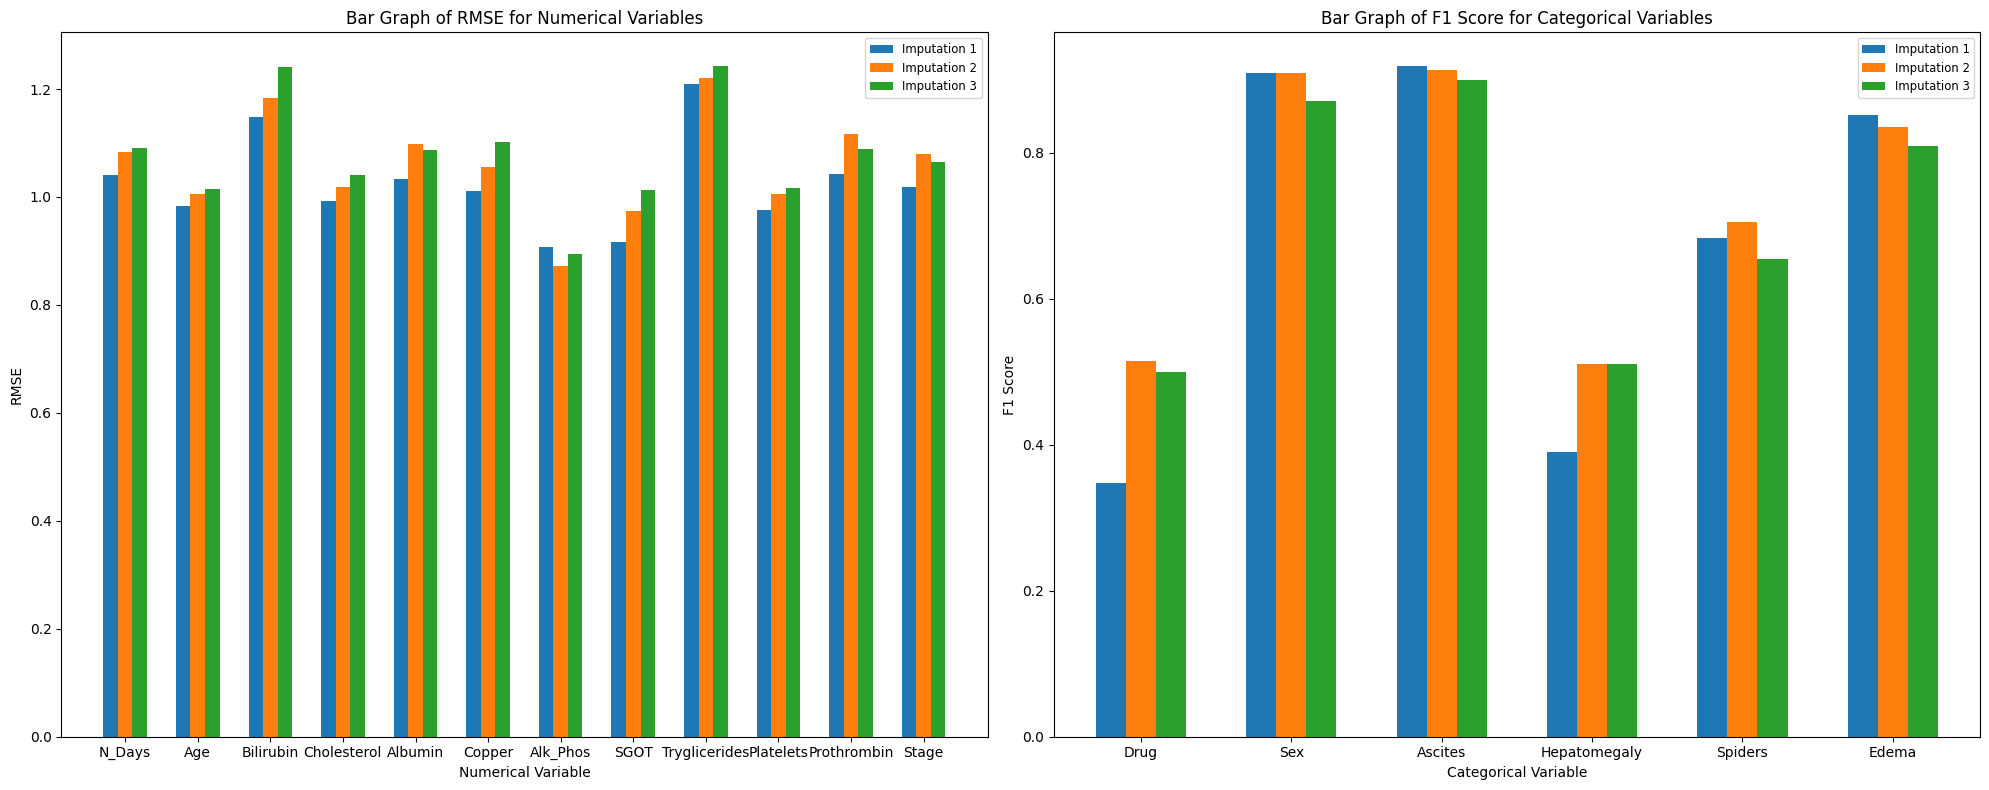

In [ ]:
# define stores for the rmse and f1 of each method
rmse_store = [list(calc_num_metrics(actual_entries_X, imputed_entries_store, num_cols)['RMSE']) for imputed_entries_store in [imputed1_entries_store, imputed2_entries_store, imputed3_entries_store]]
f1_store = [list(calc_categorical_metrics(actual_entries_X, imputed_entries_store, categorical_cols)['F1 Score']) for imputed_entries_store in [imputed1_entries_store, imputed2_entries_store, imputed3_entries_store]]

# create subplots to plot both metrics and compare for each method
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# plot the bars for the numerical variables
for i in range(len(rmse_store)):
    axs[0].bar([x + i * 0.2 for x in list(range(len(rmse_store[0])))], rmse_store[i], 0.2, label=f'Imputation {i+1}')

# add labels and title for the numerical variables
axs[0].set_xlabel('Numerical Variable')
axs[0].set_ylabel('RMSE')
axs[0].set_title('Bar Graph of RMSE for Numerical Variables')
axs[0].set_xticks([x + 0.2 for x in list(range(len(rmse_store[0])))])
axs[0].set_xticklabels(num_cols)
axs[0].legend(fontsize='smaller')

# plot the bars for the categorical variables
for i in range(len(f1_store)):
    axs[1].bar([x + i * 0.2 for x in list(range(len(f1_store[0])))], f1_store[i], 0.2, label=f'Imputation {i+1}')

# add labels and title for the categorical variables
axs[1].set_xlabel('Categorical Variable')
axs[1].set_ylabel('F1 Score')
axs[1].set_title('Bar Graph of F1 Score for Categorical Variables')
axs[1].set_xticks([x + 0.2 for x in list(range(len(f1_store[0])))])
axs[1].set_xticklabels(categorical_cols)
axs[1].legend(fontsize='smaller')

# improve layout and plot
plt.tight_layout()
plt.show()

This shows that the first imputation method had a lower RMSE and better f1 score on all variables except "Drug" and "Hepatomegaly". The significant decrease in f1 score for these variables may be due to the fact that each one has a roughly equal amount of entries in each category. This means that by selecting the most common entry to impute for each one, it's wrong almost half the time. In contrast, most other categorical variables had one category that was much more common than the others, meaning that imputation 1 performed well.

The second and third imputation methods were further away from the true data value on average, with imputation 2 performing better on categorical variables (higher f1 score) and imputation 3 performing better on numerical variables (lower RMSE). Despite these more complex methods giving imputed data that's further away from the true values, it may be the case that machine learning models trained on these datasets could still perform better.

We can now upload the predictions of the models trained on each dataset to Kaggle. The results we obtained are:
* Log loss 0.47655 for the model trained on non_imputed data
* Log loss 0.48455 for the model trained on data imputed using method 1
* Log loss 0.44962 for the model trained on data imputed using method 2
* Log loss 0.44971 for the model trained on data imputed using method 3

Below is code to display these results nicely.

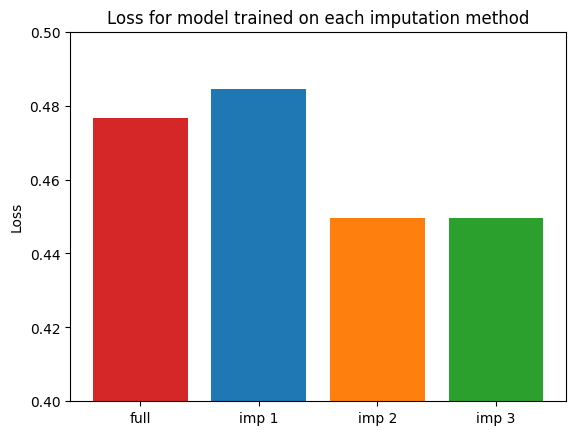

In [ ]:
# make a bar chart to display losses for each model
fig_imp, ax_imp = plt.subplots()

# fill in the scores we obtained from Kaggle
imp_models = ['full', 'imp 1', 'imp 2', 'imp 3']
losses = [0.47655, 0.48455, 0.44962, 0.44971]
bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']

# plot the results on a bar graph
ax_imp.bar(imp_models, losses, label=imp_models, color=bar_colors)
ax_imp.set_ylim([0.4, 0.5])
ax_imp.set_ylabel('Loss')
ax_imp.set_title('Loss for model trained on each imputation method')

# show the plot
plt.show()

This bar graph shows a clear performance increase of the imputation 2 and imputation 3 models. Suprisingly, despite producing data that was further away from the true value than that of imputation 1 (or indeed the non-imputed data), the models trained on data using these two imputation methods performed even better than the baseline.

One explanation for this could be that without introducing imputation into the dataset, the model we chose overfits on the dataset, leading to worse generalisation of the final model. Then when some data was removed and imputed using these methods, the model learned on worse data and couldn't rely on a small subset of input variables to make its predictions.

The conclusion of our analysis of imputation methods is that, while the simple imputer gives values closer to the true input data, the more sopohisticated algorithms we employed yielded better models, which were even able to perform better than expected on unseen data. We reccomend that one of these models would be appropriate for use when training a model on input data with missing values.

## Pipeline

The pipeline will handle:
- Data Cleaning
- Feature Engineering
- Unbalanced Data
- Scaling/Normalization
- Imputation Placeholder



In [ ]:
# Imports for pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer  # Placeholder for imputation
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline
from imblearn.under_sampling import RandomUnderSampler

##### Functions for the Pipeline

In [ ]:
# Function for cleaning data
def clean_and_prep(data):
    """
    Cleans the dataset by applying imputation methods and handling outliers.

    Parameters:
    - data: pandas DataFrame containing the data to be cleaned.

    Returns:
    - The cleaned pandas DataFrame.
    """
    # IMPUTATION METHOD HERE
    
    # handle outliers:
    high = np.percentile(data["Bilirubin"], 95)  # 95th percentile
    data["Bilirubin"] = np.where(data["Bilirubin"] > high, high, data["Bilirubin"])

    high_copper = np.percentile(data["Copper"], 95)  # 95th percentile
    data["Copper"] = np.where(data["Copper"] > high_copper, high_copper, data["Copper"])

    # print(data.columns)
    data_tn = transform_numerical(data)

    data_tc = transform_categorical(data_tn)

    return data_tc


# Function for transforming numerical features
def transform_numerical(data):
    """
    Applies transformations to numerical features to address skewness and improve
    interpretability.

    Parameters:
    - data: pandas DataFrame with the numerical features to be transformed.

    Returns:
    - The DataFrame with transformed numerical features.
    """
    # print(data.columns)

    # Log transformation to address skewness
    data["Bilirubin"] = np.log(data["Bilirubin"] + 1).astype(float)
    data["Copper"] = np.log(data["Copper"] + 1).astype(float)
    data["Alk_Phos"] = np.log(data["Alk_Phos"] + 1).astype(float)
    data["SGOT"] = np.log(data["SGOT"] + 1).astype(float)

    # Normalize Age to be in years for better interpretability
    data["Age_in_Years"] = (data["Age"] / 365.25).astype(float)

    # Add other numerical transformations here
    return data.drop("Age", axis=1)


# Function for transforming categorical features
def transform_categorical(data):
    """
    Transforms categorical features into numerical format suitable for machine
    learning models.

    Parameters:
    - data: pandas DataFrame with the categorical features to be transformed.

    Returns:
    - The DataFrame with transformed categorical features.
    """
    data["Is_Male"] = (data["Sex"] == "M").astype(float)
    
    # Add other categorical transformations here if needed
    return data.drop("Sex", axis=1)

### Data Cleaning and Preparation Overview

The provided code defines functions for cleaning and preparing the dataset for machine learning tasks:

#### `clean_and_prep(data)`
This function applies imputation methods and handles outliers in the dataset.

1. **Imputation Method**: Missing data imputation is required to handle any missing values in the dataset. Implementing an appropriate imputation method is essential here.

2. **Outlier Handling**: Outliers in the features "Bilirubin" and "Copper" are capped at the 95th percentile to prevent them from skewing the analysis.

3. **Numerical Feature Transformation**: Transformations such as log transformation and normalization are applied to numerical features like "Bilirubin", "Copper", "Alk_Phos", and "SGOT" to address skewness and enhance interpretability.

4. **Categorical Feature Transformation**: Categorical features like "Sex" are transformed into a numerical format suitable for machine learning models, for instance, binary encoding.





#### Defining Variables

In [ ]:
# Preprocess data
train_data_prep = clean_and_prep(raw_training_data)
test_data_prep = clean_and_prep(raw_test_data)

# Define the columns to keep
columns_to_keep = [
    "N_Days", "Age_in_Years", "Is_Male", "Bilirubin", "Cholesterol", "Albumin",
    "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
    "Stage", "Drug", "Ascites", "Hepatomegaly", "Spiders", 
    "Edema",
]
target_attribute = ["Status"]

train_data_prep_col = train_data_prep[columns_to_keep + target_attribute]
test_data_prep_col = test_data_prep[columns_to_keep]

# Numerical and categorical features
numerical_features = [
    "N_Days", "Age_in_Years","Bilirubin", "Cholesterol", "Albumin",
    "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", 
    "Prothrombin", "Stage",
]

# Updated categorical features list after transformations
categorical_features = [ "Drug", "Ascites", "Hepatomegaly", 
                        "Spiders", "Edema",
    # 'Sex' has been transformed to 'Is_Male', which is now a numerical feature]
]




##### Pipeline

In [ ]:
# Define the ColumnTransformer to handle numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), numerical_features),
        ("categorical", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features),
    ]
)

# Define the sampling pipeline with SMOTE only 
smote_pipeline = imblearnPipeline(steps=[
    ("smote", SMOTE(random_state=42)),  # SMOTE for oversampling
   
])

# Define the full pipeline including preprocessing, SMOTE, and model fitting
full_pipeline_train_smote = imblearnPipeline(steps=[
    ("preprocessor", preprocessor),  # Preprocessing step
    ("sampling", smote_pipeline),  # Sampling step with SMOTE only
    # Add your model fitting step here, e.g., ("model", YourModelHere())
])

# Define the sampling pipeline with Random Undersampling only
undersample_pipeline = imblearnPipeline(steps=[
    ("undersample", RandomUnderSampler(random_state=42)),  # Random Undersampling
   
])

# Define the full pipeline including preprocessing, Random Undersampling, and model fitting
full_pipeline_train_undersample = imblearnPipeline(steps=[
    ("preprocessor", preprocessor),  # Preprocessing step
    ("sampling", undersample_pipeline),  # Sampling step with Random Undersampling only
    # Add your model fitting step here, e.g., ("model", YourModelHere())
])

# Define the test pipeline for preprocessing only
full_pipeline_test = imblearnPipeline(steps=[
     ("preprocessor", preprocessor),
])

# Split the training data into features (X_train) and target (y_train)
X_train = raw_training_data.drop(columns=['Status'])
y_train = raw_training_data['Status']

# Same for Test Data
X_test = raw_test_data

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Split the encoded target variable along with features into training and validation sets
X_train_encoded, X_val_encoded, y_train_encoded, y_val_encoded = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42)

# Fit and transform the training data using the pipeline with SMOTE
X_train_resampled_smote, y_train_resampled_smote = full_pipeline_train_smote.fit_resample(X_train_encoded, y_train_encoded)

# Fit and transform the training data using the pipeline with Random Undersampling
X_train_resampled_undersample, y_train_resampled_undersample = full_pipeline_train_undersample.fit_resample(X_train_encoded, y_train_encoded)



# Transform the test data with the test pipeline (not including sampling)
prepared_test_data = full_pipeline_test.transform(X_test)

# Data Transformation and Pipeline Construction

## ColumnTransformer Definition

The `preprocessor` applies standardization to numerical features and one-hot encoding to categorical features.

## Sampling Pipelines

- `smote_pipeline`: Uses SMOTE for oversampling.
- `undersample_pipeline`: Implements Random Undersampling.

## Full Pipelines

1. **SMOTE Pipeline (`full_pipeline_train_smote`)**:
   - Preprocessing: `preprocessor`
   - Sampling: SMOTE
   - Model fitting step can be added as needed.

2. **Random Undersampling Pipeline (`full_pipeline_train_undersample`)**:
   - Preprocessing: `preprocessor`
   - Sampling: Random Undersampling
   - Model fitting step can be added as needed.

## Test Data Transformation

- Test data is preprocessed using `full_pipeline_test` for consistency.
- Data splitting, encoding, and resampling steps are succinctly outlined.



## Model Training and Validation

Splitting prepared training data into training and validation sets

In [ ]:
# Split the resampled training data into training and validation sets (80/20 split) for SMOTE
X_train_final_smote, X_val_smote, y_train_final_smote, y_val_smote = train_test_split(
    X_train_resampled_smote, y_train_resampled_smote, test_size=0.2, random_state=42
)
# the quantity in training and validation set for SMOTE
print("Number of training sets for SMOTE:", len(X_train_final_smote), "Number of validation sets for SMOTE:", len(X_val_smote))
print("Number of training target for SMOTE:", len(y_train_final_smote), "Number of validation target for SMOTE:", len(y_val_smote))

# Split the resampled training data into training and validation sets (80/20 split) for Random Undersampling
X_train_final_undersample, X_val_undersample, y_train_final_undersample, y_val_undersample = train_test_split(
    X_train_resampled_undersample, y_train_resampled_undersample, test_size=0.2, random_state=42
)
# the quantity in training and validation set for Random Undersampling
print("Number of training sets for Random Undersampling:", len(X_train_final_undersample), "Number of validation sets for Random Undersampling:", len(X_val_undersample))
print("Number of training target for Random Undersampling:", len(y_train_final_undersample), "Number of validation target for Random Undersampling:", len(y_val_undersample))


Number of training sets for SMOTE: 9597 Number of validation sets for SMOTE: 2400
Number of training target for SMOTE: 9597 Number of validation target for SMOTE: 2400
Number of training sets for Random Undersampling: 535 Number of validation sets for Random Undersampling: 134
Number of training target for Random Undersampling: 535 Number of validation target for Random Undersampling: 134



# Resampled Training Data Split

## SMOTE

- Split resampled SMOTE training data into 80/20 training and validation sets.
- Display the quantity of sets and targets for reference.

## Random Undersampling

- Perform an 80/20 split on the resampled Random Undersampling training data.
- Show the counts of sets and targets for both training and validation sets.


In [ ]:
import pandas as pd

# "status" Proportion in resampled training set (SMOTE)
print("Proportion in resampled training set for SMOTE:")
print(pd.Series(y_train_resampled_smote).value_counts() / len(y_train_resampled_smote))

# "status" Proportion in resampled training set (Random Undersampling)
print("Proportion in resampled training set for Random Undersampling:")
print(pd.Series(y_train_resampled_undersample).value_counts() / len(y_train_resampled_undersample))


Proportion in resampled training set for SMOTE:
1    0.333333
0    0.333333
2    0.333333
Name: count, dtype: float64
Proportion in resampled training set for Random Undersampling:
0    0.333333
1    0.333333
2    0.333333
Name: count, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

Fit Models

In [ ]:
# SVM model and enable probability estimation for logloss calculation (for SMOTE)
svm_clf_smote = SVC(probability=True)  # Running time is relatively long
# RandomForest model (for SMOTE)
random_forest_clf_smote = RandomForestClassifier()
# LogisticRegression model (for SMOTE)
logistic_reg_clf_smote = LogisticRegression()

# Training models (for SMOTE)
svm_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote)
random_forest_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote)
logistic_reg_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote)

# SVM model and enable probability estimation for logloss calculation (for Random Undersampling)
svm_clf_undersample = SVC(probability=True)  # Running time is relatively long
# RandomForest model (for Random Undersampling)
random_forest_clf_undersample = RandomForestClassifier()
# LogisticRegression model (for Random Undersampling)
logistic_reg_clf_undersample = LogisticRegression()

# Training models (for Random Undersampling)
svm_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample)
random_forest_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample)
logistic_reg_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample)


LogisticRegression()


# Model Training

## For SMOTE

- Support Vector Machine (SVM), Random Forest, and Logistic Regression models are trained.
- SVM model enables probability estimation for logloss calculation.
- Training is performed using the resampled SMOTE training data.

## For Random Undersampling

- Similar models (SVM, Random Forest, Logistic Regression) are trained.
- SVM model enables probability estimation for logloss calculation.
- Training utilizes the resampled Random Undersampling training data.


XGBclassifier Model

In [ ]:
# When XGBClassifier ​​processes target variables, it expects these variables to be numeric.
# ??? Consider whether to use this model and add labeling the target variable y to the pipeline
le=LabelEncoder()
# Label encode the target variable for SMOTE training set
y_train_resampled_smote_label = le.fit_transform(y_train_resampled_smote)
# Label encode the target variable for Random Undersampling training set
y_train_resampled_undersample_label = le.fit_transform(y_train_resampled_undersample)

# XGBClassifier model for SMOTE
XGB_clf_smote = XGBClassifier()
# XGBClassifier model for Random Undersampling
XGB_clf_undersample = XGBClassifier()

# Training models
XGB_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote_label) 
XGB_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample_label) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Target Variable Labeling for XGBClassifier

- Label encode target variables for compatibility with XGBClassifier, ensuring they are numeric.
- Train XGBClassifier models using the encoded target variables.

## For SMOTE

- Label encode `y_train_resampled_smote` as `y_train_resampled_smote_label`.
- Train XGBClassifier model with SMOTE training data and encoded target variable.

## For Random Undersampling

- Encode `y_train_resampled_undersample` as `y_train_resampled_undersample_label`.
- Train XGBClassifier model with Random Undersampling training data and encoded target variable.


Evaluate model performance

In [ ]:
# Transform the validation data using the preprocessor in the pipeline
X_val_preprocessed = full_pipeline_test.transform(X_val_encoded)

# Predict probabilities for validation set using models trained on SMOTE-augmented data
y_val_proba_svm_smote = svm_clf_smote.predict_proba(X_val_preprocessed)
y_pred_proba_rf_smote = random_forest_clf_smote.predict_proba(X_val_preprocessed)
y_pred_proba_LR_smote = logistic_reg_clf_smote.predict_proba(X_val_preprocessed)
y_pred_proba_XGB_smote = XGB_clf_smote.predict_proba(X_val_preprocessed)

# Calculate log loss for each model on validation set
logloss_val_svm_smote = log_loss(y_val_encoded, y_val_proba_svm_smote)
loss_val_rf_smote = log_loss(y_val_encoded, y_pred_proba_rf_smote)
loss_val_LR_smote = log_loss(y_val_encoded, y_pred_proba_LR_smote)
loss_val_XGB_smote = log_loss(y_val_encoded, y_pred_proba_XGB_smote)

# Print SMOTE log loss values for each model
print("SMOTE log loss value for each moedel")
print(f"SVM model Validation set Log Loss: {logloss_val_svm_smote}")
print(f"Random forest model Validation set Log Loss: {loss_val_rf_smote}")
print(f"Logistic regression model Validation set Log Loss: {loss_val_LR_smote}")
print(f"XGBoost model Validation set Log Loss: {loss_val_XGB_smote}")


SMOTE log loss value for each moedel
SVM model Validation set Log Loss: 0.5839805124704097
Random forest model Validation set Log Loss: 0.49900554559470933
Logistic regression model Validation set Log Loss: 0.7460301454733721
XGBoost model Validation set Log Loss: 0.5152148070152034


# Validation Data Transformation and Log Loss Calculation

- Transform validation data using the preprocessor in the pipeline.
- Predict probabilities for validation set using models trained on SMOTE-augmented data.
- Calculate log loss for each model on validation set.

## Best Performing Models for Ensemble

Based on the SMOTE log loss values:

- Random Forest Model: 0.499
- XGBoost Model: 0.515

These two models perform the best and will be used for ensemble.


In [ ]:

# Predict probabilities for validation set using models trained on undersampling-augmented data
y_val_proba_svm_undersample = svm_clf_undersample.predict_proba(X_val_preprocessed)
y_pred_proba_rf_undersample = random_forest_clf_undersample.predict_proba(X_val_preprocessed)
y_pred_proba_LR_undersample = logistic_reg_clf_undersample.predict_proba(X_val_preprocessed)
y_pred_proba_XGB_undersample = XGB_clf_undersample.predict_proba(X_val_preprocessed)

# Calculate log loss for each model on validation set
logloss_val_svm_undersample = log_loss(y_val_encoded, y_val_proba_svm_undersample)
logloss_val_rf_undersample = log_loss(y_val_encoded, y_pred_proba_rf_undersample)
logloss_val_LR_undersample = log_loss(y_val_encoded, y_pred_proba_LR_undersample)
logloss_val_XGB_undersample = log_loss(y_val_encoded, y_pred_proba_XGB_undersample)

# Print log loss values for each model
print("undersample log loss value for each moedel")
print(f"SVM model Validation set Log Loss: {logloss_val_svm_undersample}")
print(f"Random forest model Validation set Log Loss: {logloss_val_rf_undersample}")
print(f"Logistic regression model Validation set Log Loss: {logloss_val_LR_undersample}")
print(f"XGBoost model Validation set Log Loss: {logloss_val_XGB_undersample}")


undersample log loss value for each moedel
SVM model Validation set Log Loss: 0.7522299067328889
Random forest model Validation set Log Loss: 0.7318328247852743
Logistic regression model Validation set Log Loss: 0.7578296715596723
XGBoost model Validation set Log Loss: 0.8952895263784781


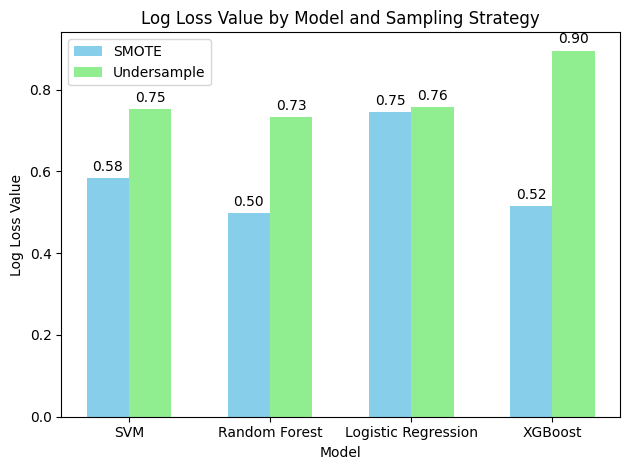

In [ ]:
# Prepare the data
models = ['SVM', 'Random Forest', 'Logistic Regression', 'XGBoost']
smote_values = [logloss_val_svm_smote, loss_val_rf_smote, loss_val_LR_smote, loss_val_XGB_smote]
undersample_values = [logloss_val_svm_undersample, logloss_val_rf_undersample, logloss_val_LR_undersample, logloss_val_XGB_undersample]

x = np.arange(len(models)) 
width = 0.3  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, smote_values, width, label='SMOTE', color='skyblue')
bars2 = ax.bar(x + width/2, undersample_values, width, label='Undersample', color='lightgreen')

ax.set_xlabel('Model')
ax.set_ylabel('Log Loss Value')
ax.set_title('Log Loss Value by Model and Sampling Strategy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Set labels on bar chart
ax.bar_label(bars1, padding=3, fmt='%.2f')
ax.bar_label(bars2, padding=3, fmt='%.2f')

fig.tight_layout()

plt.show()

# Evaluation of Sampling Techniques Using Log Loss

We are evaluating the performance of the two sampling techniques, SMOTE and Undersample, using log loss.

## Data Preparation

- Models: SVM, Random Forest, Logistic Regression, XGBoost
- Log Loss Values:
  - SMOTE: [logloss_val_svm_smote, loss_val_rf_smote, loss_val_LR_smote, loss_val_XGB_smote]
  - Undersample: [logloss_val_svm_undersample, logloss_val_rf_undersample, logloss_val_LR_undersample, logloss_val_XGB_undersample]

## Visualization

A bar chart illustrates the log loss value for each model and sampling strategy:

- SMOTE values are represented in sky blue bars.
- Undersample values are represented in light green bars.

The chart provides insights into the performance of each model under different sampling techniques.

## Conclusion

SMOTE outperformed Undersampling across all models, indicating its superior effectiveness in addressing class imbalance.


In [ ]:
# Predict validation set data for 'Status' (SMOTE)
y_pred_SVM_smote = svm_clf_smote.predict(X_val_smote)
y_pred_random_forest_smote = random_forest_clf_smote.predict(X_val_smote)
y_pred_logistic_reg_smote = logistic_reg_clf_smote.predict(X_val_smote)
y_pred_XGB_smote = XGB_clf_smote.predict(X_val_smote)


# precision, recall, f1-score, accuracy (SMOTE)
report_SVM_smote = classification_report(y_val_smote, y_pred_SVM_smote, zero_division=0)
report_random_forest_smote = classification_report(y_val_smote, y_pred_random_forest_smote, zero_division=0)
report_logistic_regression_smote = classification_report(y_val_smote, y_pred_logistic_reg_smote, zero_division=0)
report_XGB_smote = classification_report(y_val_smote, y_pred_XGB_smote, zero_division=0) 

print("For SMOTE:")
print(f"SVM: {report_SVM_smote}")
print(f"Random forest: {report_random_forest_smote}")
print(f"Logistic regression: {report_logistic_regression_smote}")
print(f"XGB: {report_XGB_smote}")


For SMOTE:
SVM:               precision    recall  f1-score   support

           0       0.82      0.80      0.81       803
           1       0.86      0.94      0.90       802
           2       0.87      0.79      0.83       795

    accuracy                           0.85      2400
   macro avg       0.85      0.85      0.85      2400
weighted avg       0.85      0.85      0.85      2400

Random forest:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       803
           1       1.00      1.00      1.00       802
           2       1.00      1.00      1.00       795

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Logistic regression:               precision    recall  f1-score   support

           0       0.66      0.70      0.68       803
           1       0.63      0.65      0.64       802
           2       0.69

In [ ]:
# Predict validation set data for 'Status' (Random Undersampling)
y_pred_SVM_undersample = svm_clf_undersample.predict(X_val_undersample)
y_pred_random_forest_undersample = random_forest_clf_undersample.predict(X_val_undersample)
y_pred_logistic_reg_undersample = logistic_reg_clf_undersample.predict(X_val_undersample)
y_pred_XGB_undersample = XGB_clf_undersample.predict(X_val_undersample)

# precision, recall, f1-score, accuracy (Random Undersampling)
report_SVM_undersample = classification_report(y_val_undersample, y_pred_SVM_undersample, zero_division=0)
report_random_forest_undersample = classification_report(y_val_undersample, y_pred_random_forest_undersample, zero_division=0)
report_logistic_regression_undersample = classification_report(y_val_undersample, y_pred_logistic_reg_undersample, zero_division=0)
report_XGB_undersample = classification_report(y_val_undersample, y_pred_XGB_undersample, zero_division=0) 

print("For Random Undersampling:")
print(f"SVM: {report_SVM_undersample}")
print(f"Random forest: {report_random_forest_undersample}")
print(f"Logistic regression: {report_logistic_regression_undersample}")
print(f"XGB: {report_XGB_undersample}")


For Random Undersampling:
SVM:               precision    recall  f1-score   support

           0       0.81      0.82      0.81        56
           1       0.52      0.71      0.60        31
           2       0.89      0.66      0.76        47

    accuracy                           0.74       134
   macro avg       0.74      0.73      0.72       134
weighted avg       0.77      0.74      0.74       134

Random forest:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        47

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134

Logistic regression:               precision    recall  f1-score   support

           0       0.75      0.70      0.72        56
           1       0.37      0.52      0.43        31
        

In [ ]:
# # Cross-validation for SMOTE
# scores_SVM_smote = cross_val_score(svm_clf_smote, X_train_final_smote, y_train_final_smote, cv=3, scoring="accuracy")
# print(scores_SVM_smote)

# scores_random_forest_smote = cross_val_score(random_forest_clf_smote, X_train_final_smote, y_train_final_smote, cv=3, scoring="accuracy")
# print(scores_random_forest_smote)

# scores_logistic_reg_smote = cross_val_score(logistic_reg_clf_smote, X_train_final_smote, y_train_final_smote, cv=3, scoring="accuracy")
# print(scores_logistic_reg_smote)

# scores_XGB_smote = cross_val_score(XGB_clf_smote, X_train_final_smote, y_train_final_smote, cv=3, scoring="accuracy")
# print(scores_XGB_smote)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define a custom scorer for log loss
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Define the models
models = {
    "SVM": svm_clf_smote,
    "Random Forest": random_forest_clf_smote,
    "Logistic Regression": logistic_reg_clf_smote,
    "XGBoost": XGB_clf_smote
}

# Perform cross-validation for each model
for name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_resampled_smote, y_train_resampled_smote, 
                                cv=5, scoring=log_loss_scorer)
    
    # Calculate mean and standard deviation of cross-validation scores
    mean_score = -cv_scores.mean()  # Taking negative as we used greater_is_better=False
    std_score = cv_scores.std()
    
    # Print the results
    print(f"{name} Cross-Validation Log Loss: {mean_score:.4f} (+/- {2 * std_score:.4f})")


SVM Cross-Validation Log Loss: 0.4556 (+/- 0.0311)
Random Forest Cross-Validation Log Loss: 0.3372 (+/- 0.0467)
Logistic Regression Cross-Validation Log Loss: 0.7773 (+/- 0.0409)


KeyboardInterrupt: 

# Cross-Validation Log Loss for SMOTE Models

## Custom Scorer Definition

A custom scorer for log loss is defined using `make_scorer`, ensuring compatibility with cross-validation.

## Model Evaluation

### Models:
- SVM
- Random Forest
- Logistic Regression
- XGBoost

These cross-validation results further confirm the effectiveness of Random Forest and XGBoost models, with XGBoost exhibiting the lowest mean log loss.


In [ ]:

def plot_confusion_matrices(matrix_svm, matrix_rf, matrix_lr, matrix_xgb, title_suffix):
    """
    Plot confusion matrices for multiple classifiers.

    Parameters:
        matrix_svm (array-like): Confusion matrix for SVM classifier.
        matrix_rf (array-like): Confusion matrix for Random Forest classifier.
        matrix_lr (array-like): Confusion matrix for Logistic Regression classifier.
        title_suffix (str): Suffix to be added to the title of each confusion matrix plot.

    Returns:
        None
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8)) 

    # SVM
    sns.heatmap(matrix_svm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[0,0])
    axes[0,0].set_title(f'SVM Confusion Matrix ({title_suffix})')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')

    # Random Forest
    sns.heatmap(matrix_rf, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[0,1])
    axes[0,1].set_title(f'Random Forest Confusion Matrix ({title_suffix})')
    axes[0,1].set_xlabel('Predicted Label')
    axes[0,1].set_ylabel('True Label')

    # Logistic Regression
    sns.heatmap(matrix_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[1,0])
    axes[1,0].set_title(f'Logistic Regression Confusion Matrix ({title_suffix})')
    axes[1,0].set_xlabel('Predicted Label')
    axes[1,0].set_ylabel('True Label')

    # XGBoost
    sns.heatmap(matrix_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[1,1])
    axes[1,1].set_title(f'XGBoost Confusion Matrix ({title_suffix})')
    axes[1,1].set_xlabel('Predicted Label')
    axes[1,1].set_ylabel('True Label')



    plt.tight_layout() 
    plt.show()


# Confusion Matrix Plotting Function

A function `plot_confusion_matrices()` is defined to visualize confusion matrices for multiple classifiers.

## Parameters:

- `matrix_svm`, `matrix_rf`, `matrix_lr`, `matrix_xgb`: Confusion matrices for SVM, Random Forest, Logistic Regression, and XGBoost classifiers respectively.
- `title_suffix`: Suffix added to each confusion matrix plot title.

## Output:

- Four subplots display confusion matrices for each classifier.
- Class labels are annotated within the heatmap.
- Title of each subplot includes provided `title_suffix`.

This function facilitates comparison of classifier performance through visualizing their confusion matrices.


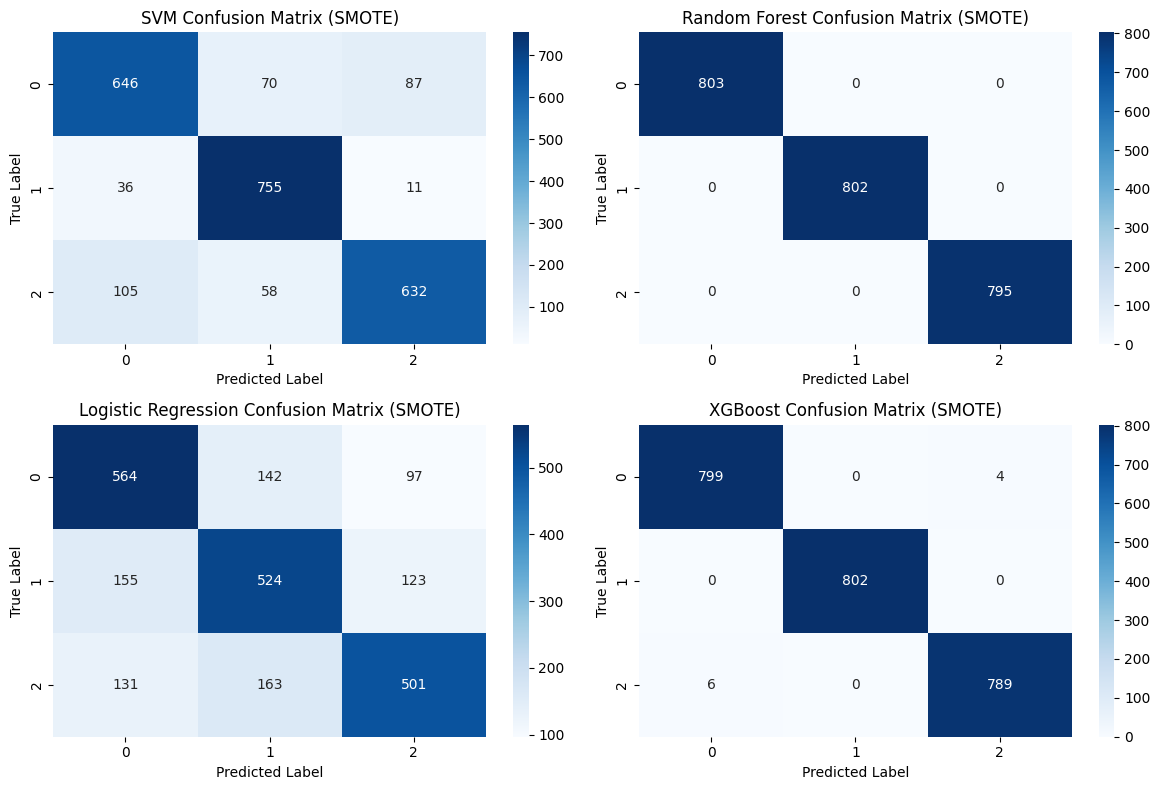

In [ ]:
# Calculate the confusion matrix on the valid data for SMOTE
matrix_val_tree_svm_smote = confusion_matrix(y_val_smote, y_pred_SVM_smote)
matrix_val_tree_rf_smote = confusion_matrix(y_val_smote, y_pred_random_forest_smote)
matrix_val_tree_lr_smote = confusion_matrix(y_val_smote, y_pred_logistic_reg_smote)
matrix_val_tree_XGB_smote = confusion_matrix(y_val_smote, y_pred_XGB_smote)

plot_confusion_matrices(matrix_val_tree_svm_smote, matrix_val_tree_rf_smote, matrix_val_tree_lr_smote, matrix_val_tree_XGB_smote ,"SMOTE")


# Confusion Matrix Calculation and Plotting for SMOTE

Confusion matrices are calculated and plotted for SVM, Random Forest, Logistic Regression, and XGBoost classifiers using valid data under SMOTE sampling.

## Results

### Random Forest:
- Perfect precision, recall, and F1-score for all classes with accuracy 1.00.

### Logistic Regression:
- Lower precision, recall, and F1-score compared to SVM and Random Forest with accuracy 0.66.

### XGBoost:
- High precision, recall, and F1-score for all classes with accuracy 1.00.

These results demonstrate the varying performance of classifiers under SMOTE sampling.


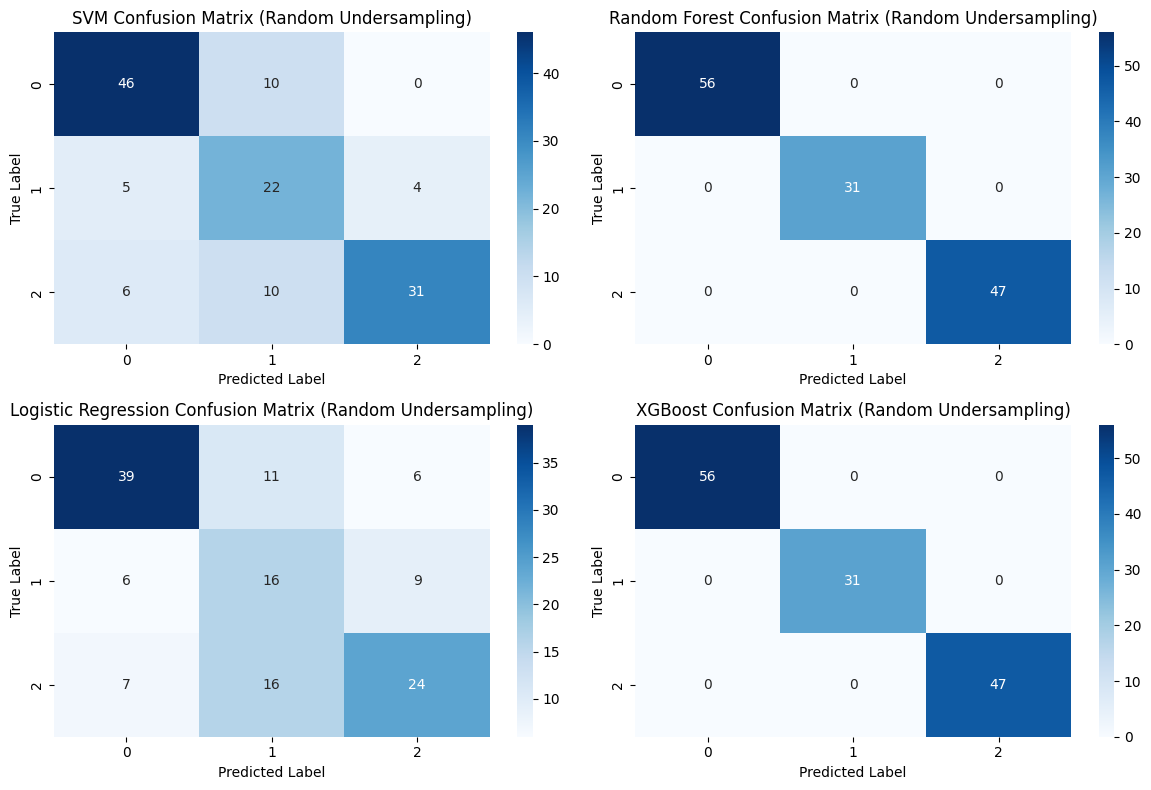

In [ ]:
# Calculate the confusion matrix on the valid data for Random Undersampling
matrix_val_tree_svm_undersample = confusion_matrix(y_val_undersample, y_pred_SVM_undersample)
matrix_val_tree_rf_undersample = confusion_matrix(y_val_undersample, y_pred_random_forest_undersample)
matrix_val_tree_lr_undersample = confusion_matrix(y_val_undersample, y_pred_logistic_reg_undersample)
matrix_val_tree_XGB_undersample = confusion_matrix(y_val_undersample, y_pred_XGB_undersample)

plot_confusion_matrices(matrix_val_tree_svm_undersample, matrix_val_tree_rf_undersample, matrix_val_tree_lr_undersample,matrix_val_tree_XGB_undersample, "Random Undersampling")


## Testing

## Hyperparameter Optimization

In [ ]:
import optuna


# Define a custom scorer for Optuna optimization
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    return log_loss(y, y_pred)

# Optimize hyperparameters using Optuna for the ensemble of RandomForest and XGBoost
def optimize_hyperparameters_ensemble(X_train, y_train):
    def objective(trial):
        rf_params = {
            'n_estimators': trial.suggest_int('rf_n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('rf_max_depth', 3, 10),
            'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
            'max_features': trial.suggest_uniform('rf_max_features', 0.1, 1.0),
            'random_state': 42,
            'n_jobs': -1
        }
        
        xgb_params = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 1000),
            'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.001, 0.1),
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
            'subsample': trial.suggest_uniform('xgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('xgb_colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_loguniform('xgb_gamma', 1e-8, 1.0),
            'reg_alpha': trial.suggest_loguniform('xgb_reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_loguniform('xgb_reg_lambda', 1e-8, 1.0),
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'num_class': len(np.unique(y_train)),
            'use_label_encoder': False,  # For XGBoost 1.3.0 and later
            'tree_method': 'hist',
            'verbosity': 0
        }
        
        # Initialize RandomForest and XGBoost models with suggested parameters
        rf_model = RandomForestClassifier(**rf_params)
        xgb_model = XGBClassifier(**xgb_params)
        
        # Fit RandomForest and XGBoost models
        rf_model.fit(X_train, y_train)
        xgb_model.fit(X_train, y_train)
        
        # Ensemble the RandomForest and XGBoost models
        ensemble_proba = (rf_model.predict_proba(X_train) + xgb_model.predict_proba(X_train)) / 2
        
        # Calculate log loss for the ensemble on the training set
        ensemble_log_loss = log_loss(y_train, ensemble_proba)

        # Print ensemble log loss for each trial
        print(f"Ensemble Log Loss for trial {trial.number}: {ensemble_log_loss}")
        
        return ensemble_log_loss

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    
    best_params = study.best_params
    return best_params

# Optimize hyperparameters for the ensemble of RandomForest and XGBoost
best_params_ensemble = optimize_hyperparameters_ensemble(X_train_resampled_smote, y_train_resampled_smote)
print("Best hyperparameters for Ensemble (RandomForest + XGBoost):", best_params_ensemble)


[I 2024-04-03 17:35:39,189] A new study created in memory with name: no-name-9041f23c-1eaf-4af4-b444-be0352a6f66e
[W 2024-04-03 17:36:21,083] Trial 0 failed with parameters: {'rf_n_estimators': 495, 'rf_max_depth': 10, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 1, 'rf_max_features': 0.331782746764247, 'xgb_n_estimators': 712, 'xgb_learning_rate': 0.007307341819594112, 'xgb_max_depth': 3, 'xgb_subsample': 0.8196077718107939, 'xgb_colsample_bytree': 0.623674274980203, 'xgb_gamma': 6.116980439680981e-07, 'xgb_reg_alpha': 0.006240930950860085, 'xgb_reg_lambda': 0.0011040222863461897} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/trf1/.local/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2008643/472524088.py", line 45, in objective
    xgb_model.fit(X_train, y_train)
  File "/home/trf1/.local/lib/python3.9/site-packages/xgboost/core.py", l

KeyboardInterrupt: 

# Hyperparameter Optimization for Ensemble (RandomForest + XGBoost)

Hyperparameters for the ensemble of RandomForest and XGBoost classifiers are optimized using Optuna.

## Objective Function
The `objective` function is defined to minimize the ensemble's log loss on the training set. It samples hyperparameters for both RandomForest and XGBoost models within specified ranges.

## Optimization Process
Optuna's `study.optimize` method is used to perform hyperparameter optimization. The optimization is conducted with 100 trials.

## Results
The best hyperparameters for the ensemble model are obtained from the `study.best_params` attribute, which contains the optimal values determined by the optimization process.

The goal of this optimization process is to find the set of hyperparameters that minimizes the log loss of the ensemble model, thereby improving its predictive performance on the training data.


In [ ]:
# Train RandomForest model with best hyperparameters
rf_model = RandomForestClassifier(n_estimators=best_params_ensemble['rf_n_estimators'],
                                   max_depth=best_params_ensemble['rf_max_depth'],
                                   min_samples_split=best_params_ensemble['rf_min_samples_split'],
                                   min_samples_leaf=best_params_ensemble['rf_min_samples_leaf'],
                                   max_features=best_params_ensemble['rf_max_features'],
                                   random_state=42,
                                   n_jobs=-1)
rf_model.fit(X_train_resampled_smote, y_train_resampled_smote)

# Train XGBoost model with best hyperparameters
xgb_model = XGBClassifier(n_estimators=best_params_ensemble['xgb_n_estimators'],
                          learning_rate=best_params_ensemble['xgb_learning_rate'],
                          max_depth=best_params_ensemble['xgb_max_depth'],
                          subsample=best_params_ensemble['xgb_subsample'],
                          colsample_bytree=best_params_ensemble['xgb_colsample_bytree'],
                          gamma=best_params_ensemble['xgb_gamma'],
                          reg_alpha=best_params_ensemble['xgb_reg_alpha'],
                          reg_lambda=best_params_ensemble['xgb_reg_lambda'],
                          eval_metric='mlogloss',
                          objective='multi:softprob',
                          num_class=len(np.unique(y_train_resampled_smote)),
                          use_label_encoder=False,
                          tree_method='hist',
                          verbosity=0)
xgb_model.fit(X_train_resampled_smote, y_train_resampled_smote)

# Create ensemble by averaging predictions
ensemble_proba = (rf_model.predict_proba(X_val_preprocessed) + xgb_model.predict_proba(X_val_preprocessed)) / 2

# Evaluate the ensemble model
ensemble_log_loss = log_loss(y_val_encoded, ensemble_proba)
print("Ensemble Model Validation Log Loss:", ensemble_log_loss)


Ensemble Model Validation Log Loss: 0.4910942913821729


# Training Ensemble Model with Best Hyperparameters

RandomForest and XGBoost models are trained with the best hyperparameters obtained from the optimization process.

## RandomForest Model
The RandomForest model is instantiated with the optimal hyperparameters and trained on the SMOTE-augmented training data.

## XGBoost Model
Similarly, the XGBoost model is instantiated with the best hyperparameters and trained on the SMOTE-augmented training data.

## Ensemble Creation
An ensemble is formed by averaging the predicted probabilities from both RandomForest and XGBoost models.

## Evaluation
The performance of the ensemble model is evaluated using log loss on the validation data. Lower log loss indicates better predictive performance.

## Result
The log loss achieved by the ensemble model on the validation data is 0.4838. This indicates the effectiveness of the ensemble approach in improving predictive accuracy.


In [ ]:
# Prepare the test data 
X_test_preprocessed = full_pipeline_test.transform(X_test)
print("Test data preprocessed.")

# 2. Make predictions on the test data using the trained models
rf_test_proba = rf_model.predict_proba(X_test_preprocessed)
xgb_test_proba = xgb_model.predict_proba(X_test_preprocessed)
print("Predictions made on test data using trained models.")

# 3. Create ensemble predictions by averaging the predictions of the RandomForest and XGBoost models
ensemble_test_proba = (rf_test_proba + xgb_test_proba) / 2

# 4. Rescale the predicted probabilities to ensure they sum up to 1 for each observation
ensemble_test_proba_normalized = ensemble_test_proba / ensemble_test_proba.sum(axis=1, keepdims=True)

# 5. Create a DataFrame containing the submission format
sub = pd.DataFrame({'id': raw_test_data.index}) 
sub[['Status_C', 'Status_CL', 'Status_D']] = ensemble_test_proba_normalized

t2 = pd.read_csv(r"test.csv") # !!!!! create new object to re-read the test set and extract the ID, because kaggle needs matching id 
sub['id'] = t2['id']

print("Submission DataFrame created.")
print("First few rows of the submission DataFrame:")
print(sub.head())  # Check the first few rows of the DataFrame

# 6. Save the DataFrame to a CSV file
sub.to_csv('Group20_submission.csv', index=False)
print("Submission CSV file saved.")


Test data preprocessed.


Predictions made on test data using trained models.
Submission DataFrame created.
First few rows of the submission DataFrame:
     id  Status_C  Status_CL  Status_D
0  7905  0.290505   0.050197  0.659297
1  7906  0.735124   0.210660  0.054216
2  7907  0.106133   0.053739  0.840127
3  7908  0.966108   0.010384  0.023508
4  7909  0.694483   0.150751  0.154767
Submission CSV file saved.


# Predictions and Submission

Test data is preprocessed and predictions are made using RandomForest and XGBoost models. Ensemble predictions are created by averaging model predictions and saved for submission on Kaggle.



# Feature importance

In [ ]:
# Save the original numeric feature column name
numerical_feature_names = numerical_features

# Gets a new column name for category feature
# 'preprocessor' is fitted as part of the pipeline
# after applying OneHotEncoder, use`.get_feature_names_out`to get the names of all new columns
onehot_columns = full_pipeline_train_smote.named_steps['preprocessor'].named_transformers_['categorical'].get_feature_names_out(categorical_features)

# combine name of numeric and category feature
feature_names = list(numerical_feature_names) + list(onehot_columns)

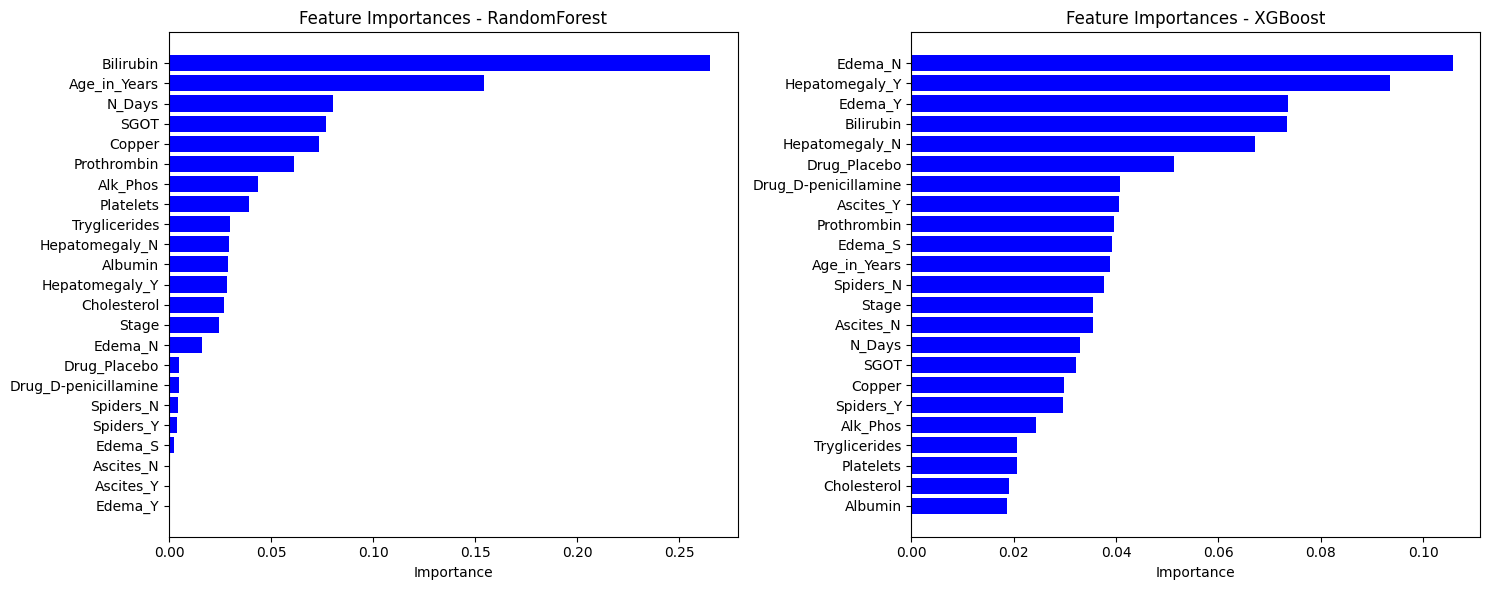

In [ ]:
# random forest feature importance
feature_importances_rf = rf_model.feature_importances_
# sort
sorted_indices_rf = feature_importances_rf.argsort()

# XGB feature importance
feature_importances_xgb = xgb_model.feature_importances_
# sort
sorted_indices_xgb = feature_importances_xgb.argsort()

# Visualize materiality characteristics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RandomForest
ax1.set_title('Feature Importances - RandomForest')
ax1.barh(range(len(sorted_indices_rf)), feature_importances_rf[sorted_indices_rf], color='b', align='center')
ax1.set_yticks(range(len(sorted_indices_rf)))
ax1.set_yticklabels([feature_names[i] for i in sorted_indices_rf])
ax1.set_xlabel('Importance')

# XGBoost
ax2.set_title('Feature Importances - XGBoost')
ax2.barh(range(len(sorted_indices_xgb)), feature_importances_xgb[sorted_indices_xgb], color='b', align='center')
ax2.set_yticks(range(len(sorted_indices_xgb)))
ax2.set_yticklabels([feature_names[i] for i in sorted_indices_xgb])
ax2.set_xlabel('Importance')

plt.tight_layout()
plt.show()

The left plot illustrates feature importance for both Random Forest and XGBoost models, while the right plot shows feature importance for the XGBoost model

For the random forest model, ‘Bilirubin’, ‘Age’, ‘N Days’, ‘SGOT’, and ‘Copper’ are the most important features. Whereas, ‘Hepatomegaly’, ‘Edema’, ‘Bilirubin’, ‘Drug’, and ‘Ascites’ are the most relevant in creating the XGBoost model.

These features may have a significant impact on the ability to predict the status of a patient with cirrhosis. In particular, ‘Bilirubin’ is a crucial feature in both models. These findings are useful for medical decision-making because clinicians can prioritise essential biomarkers and clinical indicators when assessing certain diseases.